# Stable expression for normalization

In this notebook, the quest is to find a (set of) protein(s) that have very stable expression across cell lines. <br>
If this is found, the abundances can be scaled on those proteins to make the abundances across projects more comparable and limit batch effects.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Atlas_creation/pooled_proteome_nsaf_1.csv")
data = data.pivot(index = "assay_id", columns = "uniprot_id", values = "NSAF")
metadata = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Atlas_creation/metadata_NSAF_atlas.csv")
dataset = pd.merge(data, metadata[["assay_id", "tissue_type", "PXD_accession"]], on = "assay_id", right_index=True)
#Left out due to not being pooled, due to not all the pool files being available
dataset = dataset[dataset.PXD_accession != "PXD009149"]
#Left out due to <10 protein ids
'''
assay_id    prot_ids
32491       7
32492       4
32493       6
'''
dataset = dataset[~dataset.index.isin([32491, 32492, 32493])]

dataset.reset_index(inplace=True)
assay_ids = dataset.pop("assay_id")
dataset = dataset.loc[:, ~dataset.columns.isin("tissue_type PXD_accession".split())]
metadata = metadata[metadata['assay_id'].isin(assay_ids)].reset_index(drop = True)
metadata.loc[metadata.tissue_type == "T-cell", ["tissue_type"]] = "blood"

In [6]:
metadata[metadata.PXD_accession == "PXD002057"]

assay_id cell_line PXD_accession tissue_type
142     31344     SKBR3     PXD002057      breast
143     31345     SKBR3     PXD002057      breast
144     31346     SKBR3     PXD002057      breast
145     31347     SKBR3     PXD002057      breast
146     31348     SKBR3     PXD002057      breast
147     31349     SKBR3     PXD002057      breast

In [61]:
metadata.groupby("PXD_accession").nunique()

assay_id  cell_line  tissue_type
PXD_accession                                  
PXD000426             2          1            1
PXD000443             1          1            1
PXD000529             4          1            1
PXD000533             4          2            1
PXD000612             6          1            1
PXD000661            15          4            4
PXD001327             2          1            1
PXD001352            10          3            3
PXD001441             1          1            1
PXD001468             1          1            1
PXD002057             6          1            1
PXD002613             7          1            1
PXD002842             8          1            1
PXD003252             8          1            1
PXD003406            14          1            1
PXD003407            14          1            1
PXD003530             9          1            1
PXD003668            40         11            1
PXD003790            48          1            1
PXD003896            11          1            1
PXD003903             4          1            1
PXD004182             4          1            1
PXD004280            42          1            1
PXD004452             3          1            1
PXD004900             6          1            1
PXD004940             6          1            1
PXD005045            18          2            1
PXD005354            17          1            1
PXD005912             1          1            1
PXD005940            10         10            9
PXD006035             4          1            1
PXD006112            12          1            1
PXD006591             6          1            1
PXD007543            24          1            1
PXD007759             6          1            1
PXD008222            16          8            1
PXD008381             2          1            1
PXD008693             1          1            1
PXD008719            24          2            1
PXD008996            24          1            1
PXD009442             5          1            1
PXD009560            24          1            1
PXD010538            18          1            1
PXD016742             1          1            1
PXD017391            18          1            1
PXD018066             3          1            1

<AxesSubplot:>

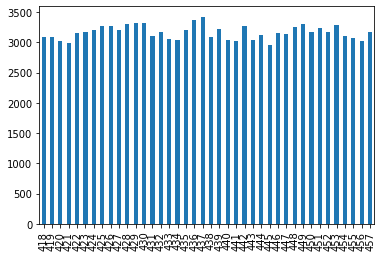

In [62]:
# Many ovarian cancer cell lines
dataset.loc[metadata[metadata.PXD_accession == "PXD003668"].index,:].notna().sum(axis = 1).plot(kind = "bar")

Finding stable proteins in this heterogenous dataset

<AxesSubplot:>

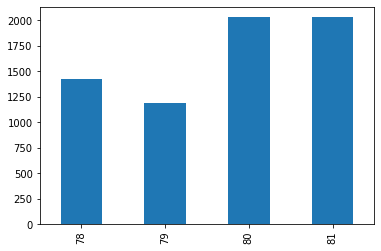

In [4]:
dataset.loc[metadata[metadata.PXD_accession == "PXD006035"].index,:].notna().sum(axis = 1).plot(kind = "bar")

<AxesSubplot:>

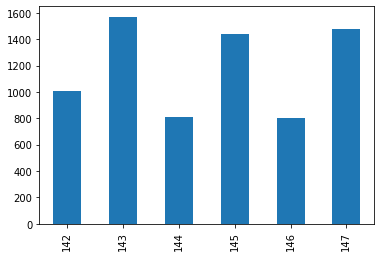

In [5]:
# Different cell lines from different tissues
dataset.loc[metadata[metadata.PXD_accession == "PXD002057"].index,:].notna().sum(axis = 1).plot(kind = "bar")

<AxesSubplot:>

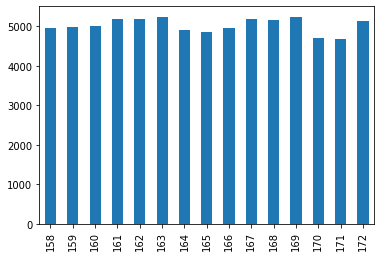

In [4]:
dataset.loc[metadata[metadata.PXD_accession == "PXD000661"].index,:].notna().sum(axis = 1).plot(kind = "bar")

In [3]:
def evaluate_stability(pxd_accession: str):
    '''returns std/mean of the proteins'''
    subset = dataset.loc[metadata[metadata.PXD_accession == pxd_accession].index,:]
    all_ided = subset.dropna(axis = 'columns')
    print("proteins identified in all: {}".format(all_ided.shape[1]))

    all_std = all_ided.std(axis = 0)
    all_mean = all_ided.mean(axis = 0)

    plt.figure(figsize = (20,7))
    plt.xlabel("std")
    plt.ylabel("mean")
    fig = sns.scatterplot(x = all_std, y = all_mean)

    for i in range(0, all_ided.shape[1]):
        fig.text(all_std[i] + .0001, all_mean[i] +.0001, all_ided.columns[i])

    print((all_std/all_mean).sort_values())
    return (all_std/all_mean).sort_values()

proteins identified in all: 694
P36404    0.167637
Q8N1G4    0.182038
P23246    0.194013
P04264    0.199113
Q07666    0.227666
            ...   
O00151    1.341434
Q96SZ5    1.573760
Q9NR30    1.597124
Q9NQW6    1.694094
P30050    1.724508
Length: 694, dtype: float64


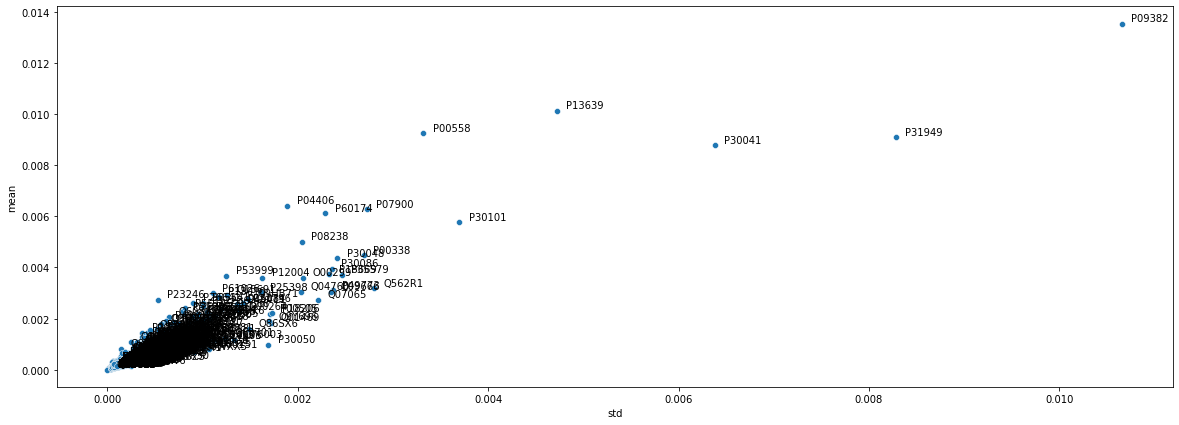

In [69]:
PXD05940_stab = evaluate_stability("PXD005940")

proteins identified in all: 1018
Q14152    0.112437
Q6P2Q9    0.121810
Q92900    0.130984
Q02878    0.132073
P55060    0.132444
            ...   
Q9NU22    0.763690
Q9H1E3    0.787981
Q00653    0.798622
P63313    0.811001
P06756    0.832419
Length: 1018, dtype: float64


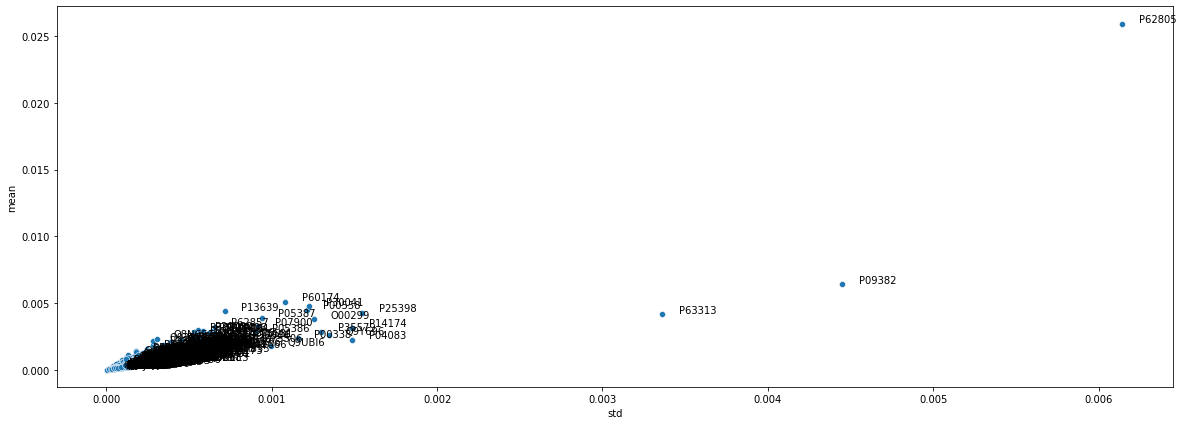

In [70]:
PXD03668_stab = evaluate_stability("PXD003668")

proteins identified in all: 903
P40227    0.155134
P50991    0.168788
P31948    0.188214
P43686    0.198766
Q15393    0.203722
            ...   
Q13185    1.146638
P07305    1.182006
P32119    1.190587
O15381    1.213646
Q96CT7    1.317638
Length: 903, dtype: float64


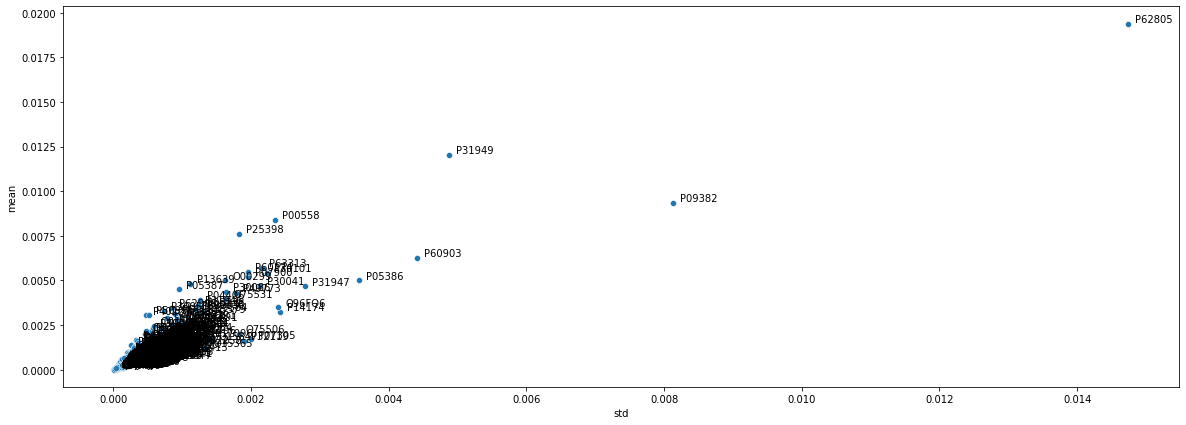

In [71]:
PXD008222_stab = evaluate_stability("PXD008222")

proteins identified in all: 1982
Q9NR30    0.108992
Q00610    0.139591
Q07666    0.140086
Q9Y5B9    0.140343
Q13435    0.142677
            ...   
P33316    1.312883
P33527    1.383254
Q9ULH0    1.434542
P31327    1.520053
Q16822    1.845995
Length: 1982, dtype: float64


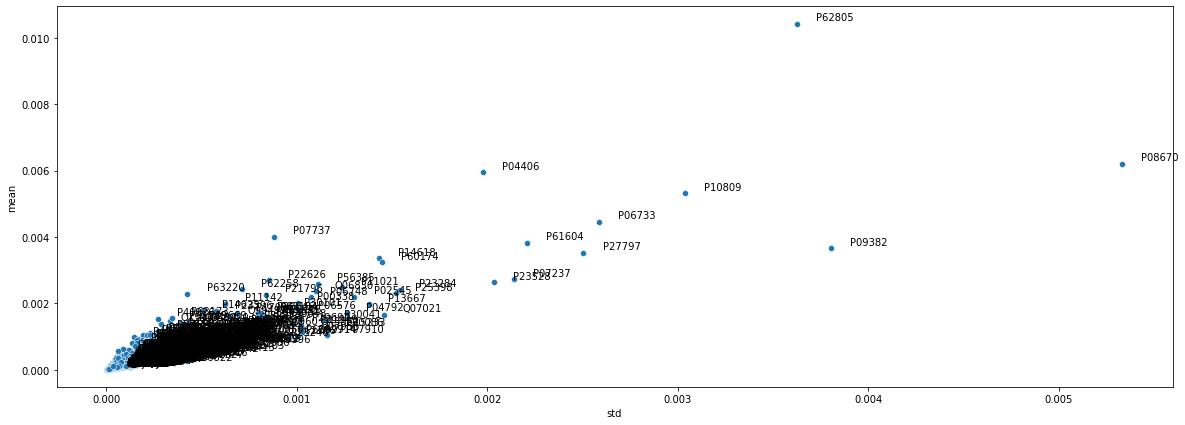

In [80]:
PXD000661_stab = evaluate_stability("PXD000661")

proteins identified in all: 2204
P13639    0.088957
Q10713    0.099092
O15371    0.114893
Q08J23    0.118876
Q13435    0.121465
            ...   
P08727    1.280619
P36551    1.387535
O95721    1.535854
Q86W92    1.614885
P49593    1.989052
Length: 2204, dtype: float64


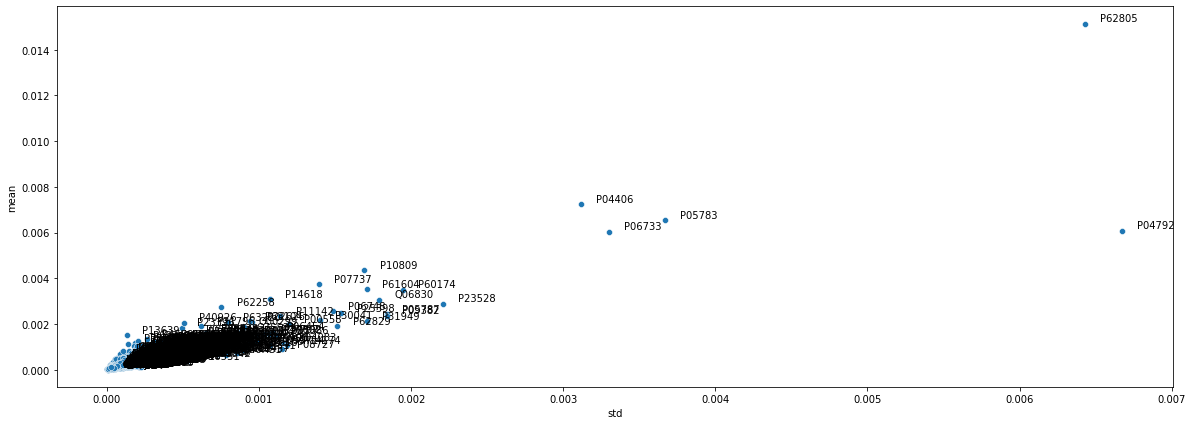

In [85]:
PXD001352_stab =  evaluate_stability("PXD001352")

In [86]:
summed = pd.merge(PXD008222_stab.reset_index(), PXD03668_stab.reset_index(), on="index").merge(PXD05940_stab.reset_index(), on = "index").merge(PXD000661_stab.reset_index(), on = "index").merge(PXD001352_stab.reset_index(), on = "index")

In [124]:
candidates = summed.set_index("index").mean(axis = 1).sort_values()

In [137]:
candidates.head(10)

index
O75533    0.224103
Q07666    0.234394
P50991    0.249249
Q9Y3I0    0.252275
P26641    0.274720
P31948    0.275166
P13639    0.275383
Q08J23    0.277855
Q96QK1    0.278387
Q15393    0.283904
dtype: float64

In [139]:
for i, candidate in enumerate(candidates.index):
    if i > 9:
        break
    print("{}: not found in {} samples\t std/mean: {:.2f}".format(candidate, len(dataset.index[dataset.loc[:, candidate].isna()]), candidates[candidate]))

O75533: not found in 62 samples	 std/mean: 0.22
Q07666: not found in 58 samples	 std/mean: 0.23
P50991: not found in 8 samples	 std/mean: 0.25
Q9Y3I0: not found in 16 samples	 std/mean: 0.25
P26641: not found in 7 samples	 std/mean: 0.27
P31948: not found in 16 samples	 std/mean: 0.28
P13639: not found in 0 samples	 std/mean: 0.28
Q08J23: not found in 22 samples	 std/mean: 0.28
Q96QK1: not found in 28 samples	 std/mean: 0.28
Q15393: not found in 35 samples	 std/mean: 0.28


In [96]:
summed[summed["index"] == "O75533"]

index       0_x       0_y       0_x       0_y         0
16  O75533  0.241991  0.132445  0.272723  0.230949  0.242406

In [101]:
summed[summed["index"] == "P13639"]

index       0_x       0_y       0_x       0_y         0
10  P13639  0.232452  0.162537  0.466616  0.426353  0.088957

The protein which is stablest across almost all samples is **'Splicing factor 3b subunit 1'** or **'O75533'** <br>
**P13639** or **Eukaryotic translation elongation factor 2** is identified in every sample and thus more useable to center around

## What is the approximate rank of P13639 in relation with #identifications

<AxesSubplot:xlabel='rank percentile', ylabel='#identifications'>

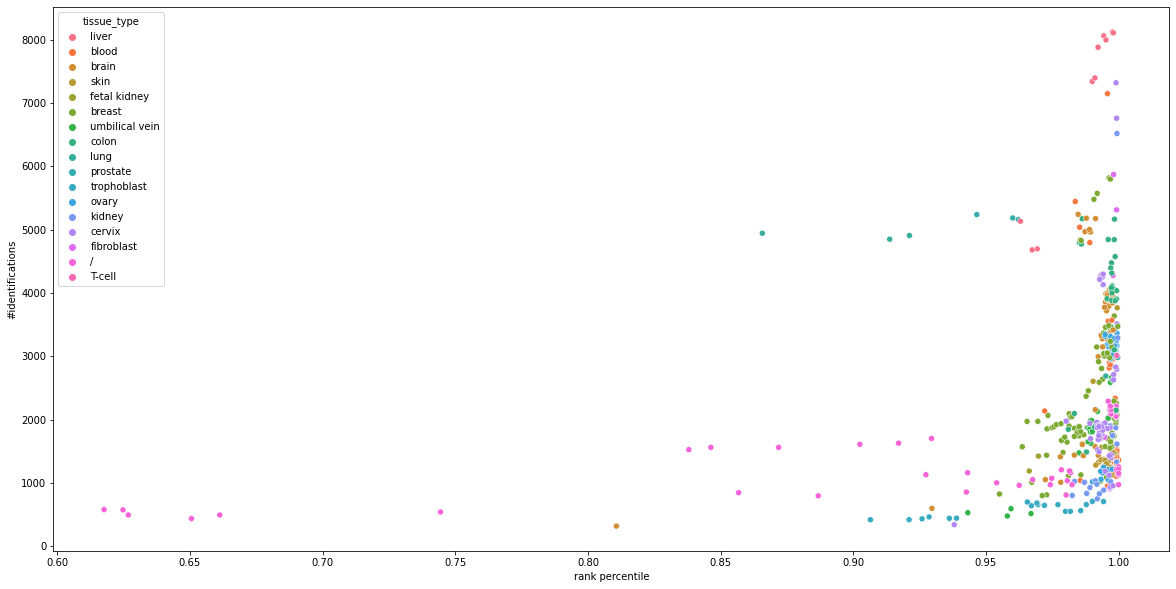

In [194]:
plt.figure(figsize = (20,10))
plt.xlabel("rank percentile")
plt.ylabel("#identifications")

sns.scatterplot(x= dataset.rank(axis = 1, pct = True, method = "average").loc[:, "P13639"], y = dataset.notna().sum(axis = 1), hue = metadata.tissue_type)

In [191]:
dataset.rank(axis = 1, pct = True, method = "average")

A0A024RBG1  A0A075B6X5  A0A096LP01  A0A096LP49  A0A0A6YYK6  A0A0B4J1V0  \
0      0.254953         NaN         NaN         NaN         NaN         NaN   
1           NaN         NaN         NaN         NaN         NaN         NaN   
2      0.245133         NaN    0.607316         NaN         NaN    0.319653   
3      0.244844         NaN    0.668979         NaN         NaN    0.316523   
4           NaN         NaN         NaN         NaN         NaN         NaN   
..          ...         ...         ...         ...         ...         ...   
505         NaN         NaN         NaN         NaN         NaN         NaN   
506    0.683037         NaN         NaN         NaN         NaN         NaN   
507         NaN         NaN         NaN         NaN         NaN         NaN   
508         NaN         NaN         NaN         NaN         NaN         NaN   
509         NaN         NaN         NaN         NaN         NaN         NaN   

     A0A0B4J2F0  A0A0J9YWL9  A0A0J9YX94  A0A0U1RRE5  ...    Q9Y6X4    Q9Y6X5  \
0           NaN         NaN         NaN         NaN  ...  0.632214  0.330134   
1           NaN         NaN         NaN         NaN  ...  0.628529  0.334731   
2           NaN    0.035524         NaN         NaN  ...       NaN       NaN   
3           NaN    0.034058         NaN         NaN  ...       NaN       NaN   
4           NaN         NaN         NaN         NaN  ...       NaN       NaN   
..          ...         ...         ...         ...  ...       ...       ...   
505         NaN         NaN         NaN         NaN  ...       NaN  0.158595   
506         NaN         NaN         NaN         NaN  ...       NaN       NaN   
507         NaN         NaN         NaN         NaN  ...       NaN       NaN   
508    0.645985         NaN         NaN         NaN  ...       NaN       NaN   
509    0.709264         NaN         NaN         NaN  ...       NaN       NaN   

       Q9Y6X8    Q9Y6X9    Q9Y6Y0    Q9Y6Y1    Q9Y6Y8    Q9Y6Y9  Q9Y6Z7  \
0    0.437369  0.509290  0.602929       NaN  0.687215       NaN     NaN   
1    0.467760  0.525583  0.539761  0.014425  0.648502       NaN     NaN   
2    0.179107  0.400248  0.533974       NaN  0.704154  0.399256     NaN   
3    0.121110  0.479440  0.466192       NaN  0.659668  0.393013     NaN   
4         NaN       NaN       NaN       NaN  0.498106       NaN     NaN   
..        ...       ...       ...       ...       ...       ...     ...   
505  0.172795  0.633931  0.610463       NaN  0.836472       NaN     NaN   
506       NaN  0.581364  0.541545       NaN  0.779135       NaN     NaN   
507  0.746256  0.754032  0.228399       NaN  0.817252       NaN     NaN   
508  0.384207  0.129728       NaN       NaN  0.222960       NaN     NaN   
509  0.073324  0.683892  0.438547       NaN  0.760708       NaN     NaN   

     W5XKT8  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
..      ...  
505     NaN  
506     NaN  
507     NaN  
508     NaN  
509     NaN  

[510 rows x 13166 columns]

The spread of P13639 expression in terms of quantile rank, meaning how much proteins are more or less expressed, is unexpectedly large and raises the question of applicability of P13639 as abundance unifier

In [179]:
dataset.rank(axis = 0, pct = True).std(axis = 0).sort_values()

P35579    0.288958
P13639    0.288958
Q08211    0.288959
Q7KZF4    0.288959
P08238    0.288960
            ...   
Q6P9H5         NaN
Q86WV1         NaN
Q96F15         NaN
Q9NR55         NaN
Q9UIV8         NaN
Length: 13166, dtype: float64

---

### Abundance equalization

Similar idea that was used in FlashLFQ with the assumption being that most proteins will not be that different in expression

In [5]:
import numpy as np

In [33]:
def get_fc_plot(sample1, sample2, index):
    '''returns list of fold changes of protein abundance between the 2 samples'''
    log_fc = []

    count = 0
    for i in range(len(sample1)):
        if sample1[i] != 0.0 and sample2[i] != 0.0:
            log_fc.append(np.log(sample1[i] / sample2[i]))
            count += 1
    
    print(f"{index}:\tcommon prots: {count}\tmedianFC: {np.median(log_fc)}\tstdFC: {np.std(log_fc)}")
    return log_fc

def plot_fc(subset, ref = None, plot_med_fc = False, color_scheme = None):
    """ref = index of the reference sample, default is first sample"""
    full_df = pd.DataFrame(columns = {"fold_change", "index"})
    if ref == None:
        ref = subset.loc[subset.index[0],:]
        ref_i = ref.name
    else:
        ref = subset.loc[ref,:]
        ref_i = ref.name

    list_med_fc = []
    indices = []
    for index, row in subset.iterrows():
        if index == ref_i:
            continue
        
        fc_list = get_fc_plot(ref, row, index)
        list_med_fc.append(np.median(fc_list))
        indices.append(index)
        df = pd.DataFrame({"fold_change": fc_list})
       
        df["index"] = index
        full_df = pd.concat([full_df, df], ignore_index = True)

    if plot_med_fc:
        fig, (ax1, ax2) = plt.subplots(1,2,figsize = (25,8))
        
        ax1.set_xlim(right= 2, left = -2)    
        ax1.set_title("Fold changes")
        ax2.set_title("median fold changes")
        if color_scheme != None:
            sns.kdeplot(data=full_df, x = "fold_change", hue = "index", palette = color_scheme, common_norm = False, alpha = .8, ax = ax1)
            sns.barplot(x = indices, y = list_med_fc, ax = ax2, palette = color_scheme,  alpha = .8)
        
        else:
            sns.kdeplot(data=full_df, x = "fold_change", hue = "index", palette = "tab10", common_norm = False, alpha = .8, ax = ax1)
            sns.barplot(x = indices, y = list_med_fc, ax = ax2, palette = "tab10",  alpha = .8)
        return
        
    plt.xlim(right= 2, left = -2)    
    sns.kdeplot(data=full_df, x = "fold_change", hue = "index", palette = "tab10", common_norm = False, alpha = .5)

1 sample is choosen as reference. Then each sample is compared pairwise and the foldchange is calculated for each protein. Than this fold change is plotted for the samples

---

83:	common prots: 1425	medianFC: 0.02209864574036481	stdFC: 0.3834200498063499
84:	common prots: 1470	medianFC: 0.15471861304064224	stdFC: 0.4126389796342092
85:	common prots: 1488	medianFC: 0.12656824347243656	stdFC: 0.4169400363809032
86:	common prots: 1468	medianFC: 0.12385200256682775	stdFC: 0.4433009267580322
87:	common prots: 1454	medianFC: 0.13074289776397743	stdFC: 0.43245767321687445
88:	common prots: 1458	medianFC: 0.2672929769273537	stdFC: 0.4595584263616846
89:	common prots: 1457	medianFC: 0.2718948056412973	stdFC: 0.4552798351742389
90:	common prots: 1407	medianFC: 0.01708834912219983	stdFC: 0.4586156002239099
91:	common prots: 1413	medianFC: 0.030887925640746588	stdFC: 0.42643350646943484
92:	common prots: 1402	medianFC: 0.005572804678636347	stdFC: 0.4554852965340539
93:	common prots: 1426	medianFC: 0.03768742815390598	stdFC: 0.476669997237412
151:	common prots: 1457	medianFC: 0.8223802040832816	stdFC: 0.9838690971361872
152:	common prots: 1458	medianFC: 0.801510751492281

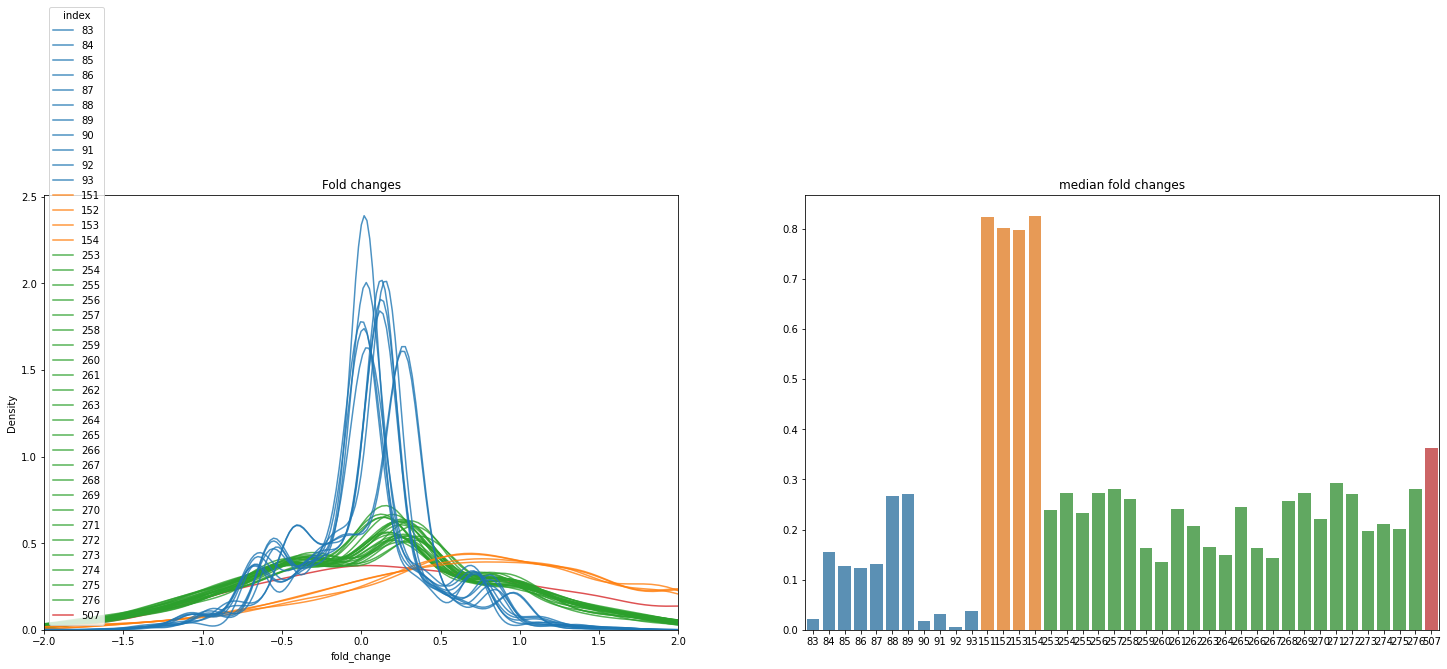

In [35]:
my_colors = ["tab:blue"]*11 + ["tab:orange"]*4 + ["tab:green"]*24 + ["tab:red"]
subset = dataset.loc[metadata[metadata.cell_line == "MCF7"].index,:].fillna(0)
#metadata[metadata.PXD_accession == "PXD000661"]
plot_fc(subset, 82, plot_med_fc=True, color_scheme = my_colors)

Try the correction done in 'coherence_analysis.ipynb'

In [55]:
absolute_dataset = dataset.apply(lambda x: x[x.notna()] * x.notna().sum(), axis = 1)

83:	common prots: 1425	medianFC: 0.006416780344443363	stdFC: 0.38342004980634997
84:	common prots: 1470	medianFC: 0.023850337835603475	stdFC: 0.4126389796342092
85:	common prots: 1488	medianFC: 0.007502680386549106	stdFC: 0.4169400363809032
86:	common prots: 1468	medianFC: -0.0005957048352884454	stdFC: 0.44330092675803223
87:	common prots: 1454	medianFC: 0.02909748123584162	stdFC: 0.43245767321687445
88:	common prots: 1458	medianFC: 0.1385603138527363	stdFC: 0.4595584263616846
89:	common prots: 1457	medianFC: 0.12778130368623772	stdFC: 0.455279835174239
90:	common prots: 1407	medianFC: -0.04077903319834897	stdFC: 0.4586156002239099
91:	common prots: 1413	medianFC: -0.036685499191978554	stdFC: 0.4264335064694349
92:	common prots: 1402	medianFC: -0.07610522633563095	stdFC: 0.4554852965340539
93:	common prots: 1426	medianFC: -0.05955511940147278	stdFC: 0.476669997237412
151:	common prots: 1457	medianFC: -0.25638082388721867	stdFC: 0.9838690971361873
152:	common prots: 1458	medianFC: -0.40

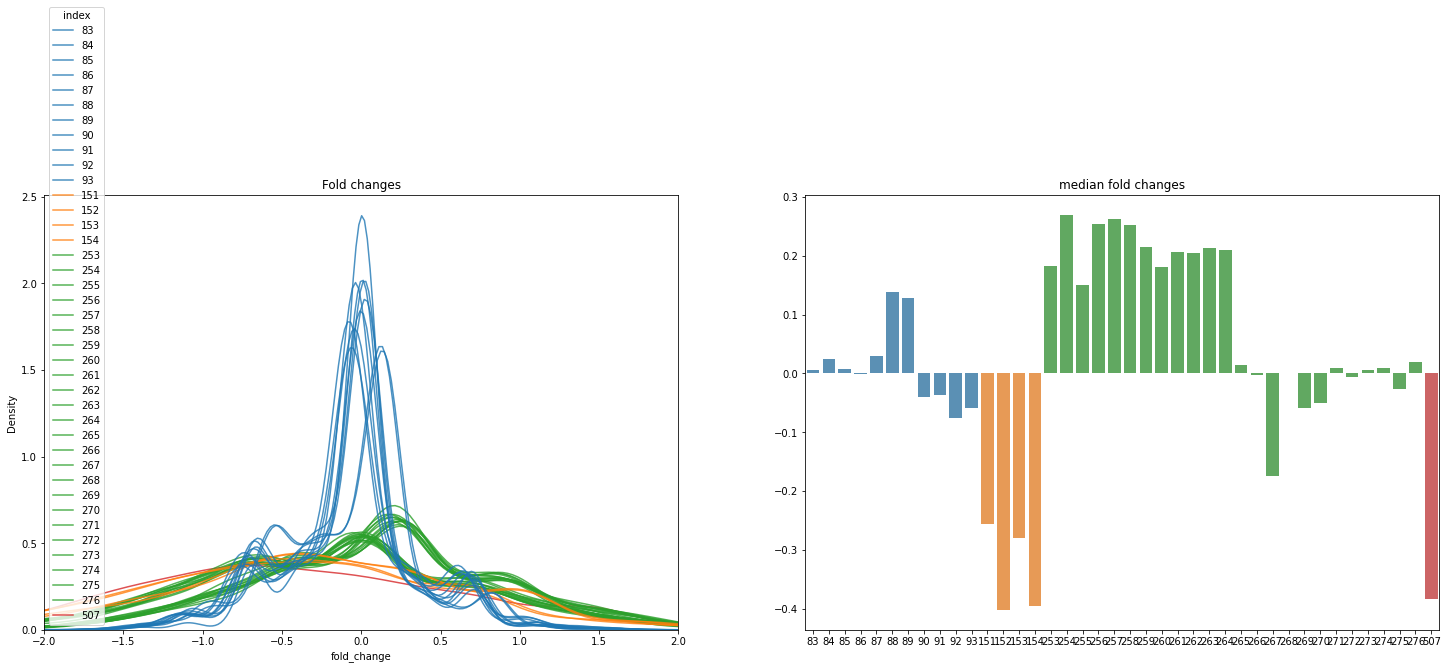

In [56]:
my_colors = ["tab:blue"]*11 + ["tab:orange"]*4 + ["tab:green"]*24 + ["tab:red"]
subset = absolute_dataset.loc[metadata[metadata.cell_line == "MCF7"].index,:].fillna(0)
#metadata[metadata.PXD_accession == "PXD000661"]
plot_fc(subset, 82, plot_med_fc=True, color_scheme = my_colors)

Clearly not perfect

Now after median fold change correction on project level only

83:	common prots: 1425	medianFC: 0.02209864574036481	stdFC: 0.3834200498063499
84:	common prots: 1470	medianFC: 0.0	stdFC: 0.4126389796342092
85:	common prots: 1488	medianFC: 2.2204460492503128e-16	stdFC: 0.4169400363809032
86:	common prots: 1468	medianFC: 0.0	stdFC: 0.44330092675803223
87:	common prots: 1454	medianFC: 0.0	stdFC: 0.43245767321687445
88:	common prots: 1458	medianFC: 0.0	stdFC: 0.4595584263616846
89:	common prots: 1457	medianFC: 0.0	stdFC: 0.4552798351742389
90:	common prots: 1407	medianFC: 0.01708834912219983	stdFC: 0.4586156002239099
91:	common prots: 1413	medianFC: 0.030887925640746588	stdFC: 0.42643350646943484
92:	common prots: 1402	medianFC: 0.005572804678636347	stdFC: 0.4554852965340539
93:	common prots: 1426	medianFC: 0.03768742815390598	stdFC: 0.476669997237412
151:	common prots: 1457	medianFC: 0.8223802040832816	stdFC: 0.9838690971361872
152:	common prots: 1458	medianFC: 0.9425360590581996	stdFC: 1.0324165355847446
153:	common prots: 1444	medianFC: 0.7969927848

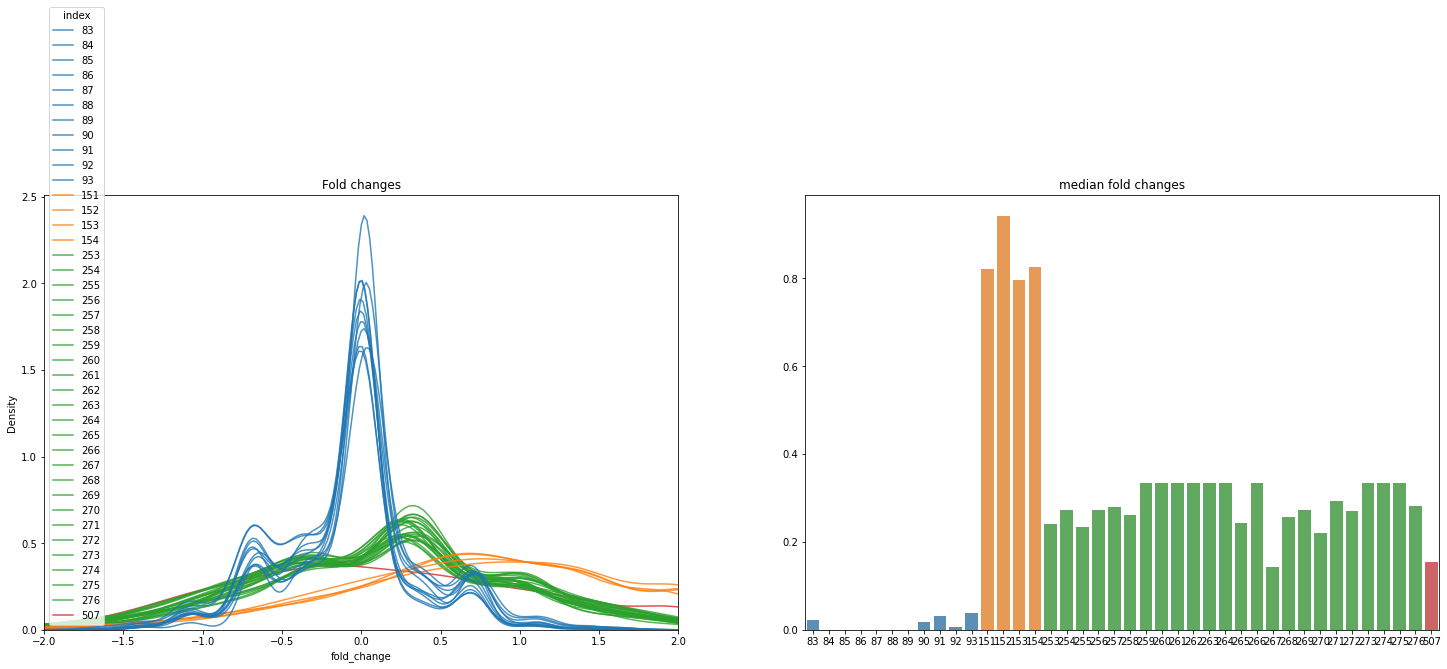

In [63]:
my_colors = ["tab:blue"]*11 + ["tab:orange"]*4 + ["tab:green"]*24 + ["tab:red"]
subset = shifted_dataset.loc[metadata[metadata.cell_line == "MCF7"].index,:].fillna(0)
#metadata[metadata.PXD_accession == "PXD000661"]
plot_fc(subset, 82, plot_med_fc=True, color_scheme = my_colors)

And on tissue level

83:	common prots: 1425	medianFC: 0.02209864574036481	stdFC: 0.3834200498063499
84:	common prots: 1470	medianFC: 0.0	stdFC: 0.4126389796342092
85:	common prots: 1488	medianFC: 2.2204460492503128e-16	stdFC: 0.4169400363809032
86:	common prots: 1468	medianFC: 0.0	stdFC: 0.44330092675803223
87:	common prots: 1454	medianFC: 0.0	stdFC: 0.43245767321687445
88:	common prots: 1458	medianFC: 0.0	stdFC: 0.4595584263616846
89:	common prots: 1457	medianFC: 0.0	stdFC: 0.4552798351742389
90:	common prots: 1407	medianFC: 0.01708834912219983	stdFC: 0.4586156002239099
91:	common prots: 1413	medianFC: 0.030887925640746588	stdFC: 0.42643350646943484
92:	common prots: 1402	medianFC: 0.005572804678636347	stdFC: 0.4554852965340539
93:	common prots: 1426	medianFC: 0.03768742815390598	stdFC: 0.476669997237412
151:	common prots: 1457	medianFC: 0.0	stdFC: 0.9838690971361872
152:	common prots: 1458	medianFC: 0.0	stdFC: 1.0324165355847446
153:	common prots: 1444	medianFC: -1.02374054324352e-05	stdFC: 0.99132299032

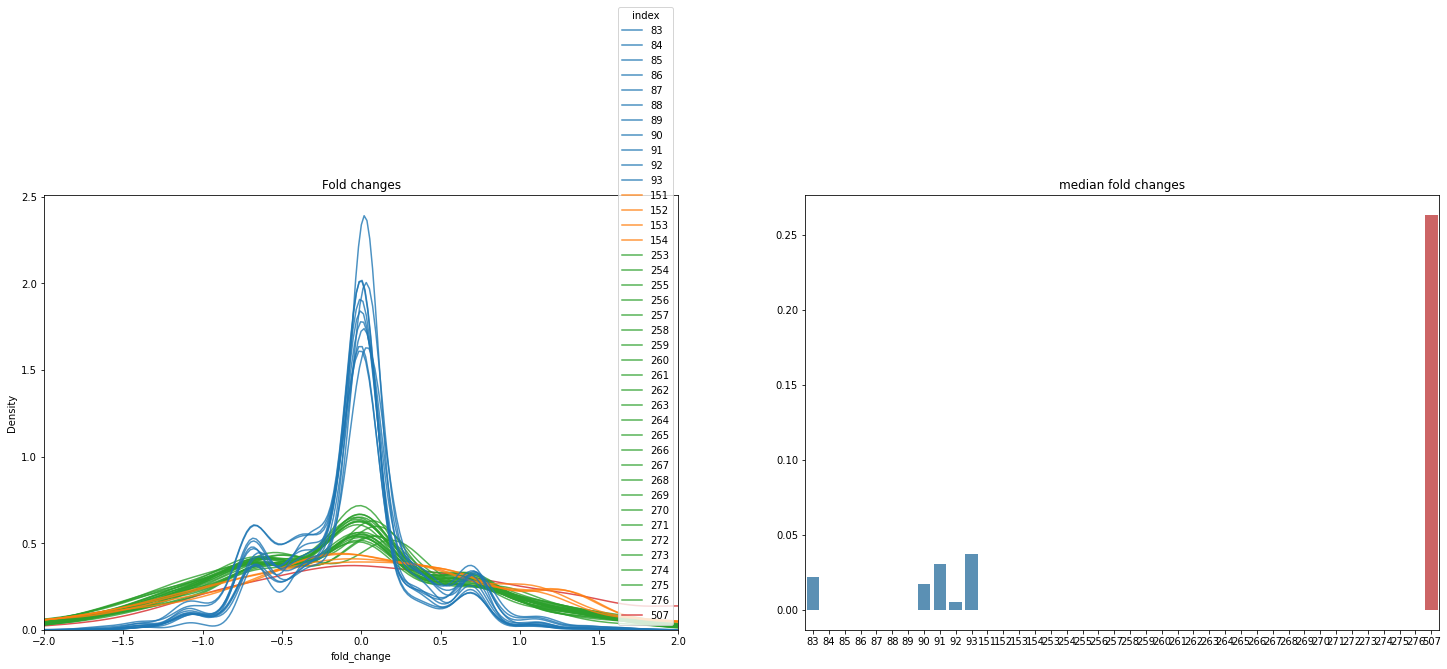

In [69]:
my_colors = ["tab:blue"]*11 + ["tab:orange"]*4 + ["tab:green"]*24 + ["tab:red"]
subset = shift_tissue_df.loc[metadata[metadata.cell_line == "MCF7"].index,:].fillna(0)
#metadata[metadata.PXD_accession == "PXD000661"]
plot_fc(subset, 82, plot_med_fc=True, color_scheme = my_colors)

---

158:	common prots: 3702	medianFC: -0.028606652543872072	stdFC: 0.8598096855112672
159:	common prots: 3716	medianFC: -0.023710712857184076	stdFC: 0.846712150582612
160:	common prots: 3722	medianFC: -0.01245269191509574	stdFC: 0.834284525397215
161:	common prots: 3381	medianFC: -0.3156186010211316	stdFC: 1.1132179212878268
162:	common prots: 3392	medianFC: -0.3111322115412727	stdFC: 1.1136479540229796
163:	common prots: 3403	medianFC: -0.27419623283901884	stdFC: 1.1043918526475083
164:	common prots: 3726	medianFC: -0.1358799495215673	stdFC: 0.7934730000283896
165:	common prots: 3694	medianFC: -0.1487002695883552	stdFC: 0.8008804764269766
166:	common prots: 3362	medianFC: -0.13278309836144941	stdFC: 1.080218099783074
167:	common prots: 3809	medianFC: -0.060678607449337424	stdFC: 0.8257503365090259
168:	common prots: 3805	medianFC: -0.08115707590688523	stdFC: 0.8297106876513447
169:	common prots: 3400	medianFC: -0.1734095775757767	stdFC: 1.1287686130561763
171:	common prots: 4209	medianFC:

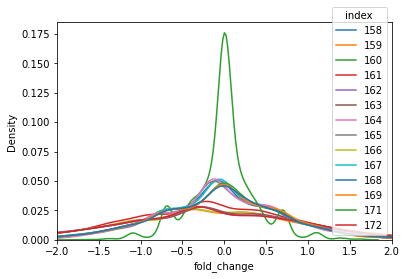

In [6]:
subset = dataset.loc[metadata[metadata.PXD_accession == "PXD000661"].index,:].fillna(0)
#metadata[metadata.PXD_accession == "PXD000661"]
plot_fc(subset, 170)

In [7]:
metadata[metadata.PXD_accession == "PXD000661"]

assay_id cell_line PXD_accession tissue_type
158     31360       U87     PXD000661       brain
159     31361       U87     PXD000661       brain
160     31362       U87     PXD000661       brain
161     31363       U87     PXD000661       brain
162     31364       U87     PXD000661       brain
163     31365       U87     PXD000661       brain
164     31366      A549     PXD000661        lung
165     31367      A549     PXD000661        lung
166     31368      A549     PXD000661        lung
167     31369       PC3     PXD000661    prostate
168     31370       PC3     PXD000661    prostate
169     31371       PC3     PXD000661    prostate
170     31372     HepG2     PXD000661       liver
171     31373     HepG2     PXD000661       liver
172     31374     HepG2     PXD000661       liver

total identifications
142    1009
143    1570
144     811
145    1437
146     799
147    1480
dtype: int64
143:	common prots: 699	medianFC: 0.2576811366782801	stdFC: 0.9020387761772387
144:	common prots: 672	medianFC: -0.1465154724038611	stdFC: 0.5350845053213165
145:	common prots: 667	medianFC: 0.35606782966675965	stdFC: 0.8929549210154407
146:	common prots: 681	medianFC: -0.15604765620812824	stdFC: 0.5152194765567539
147:	common prots: 679	medianFC: 0.37128359930453475	stdFC: 0.8968400559677046


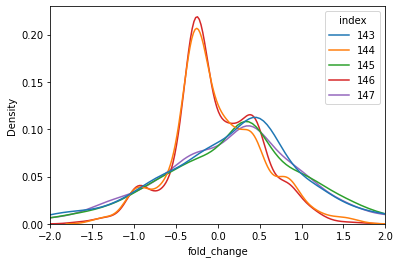

In [7]:
subset = dataset.loc[metadata[metadata.PXD_accession == "PXD002057"].index,:].fillna(0)
print(f"total identifications\n{(subset !=0).sum(axis = 1)}")
metadata[metadata.PXD_accession == "PXD002057"]
plot_fc(subset)

In [69]:
metadata[metadata.PXD_accession == "PXD006035"]

assay_id cell_line PXD_accession   tissue_type
78     31162    HEK293     PXD006035  fetal kidney
79     31163    HEK293     PXD006035  fetal kidney
80     31208    HEK293     PXD006035  fetal kidney
81     31209    HEK293     PXD006035  fetal kidney

In [130]:
rescaled = pd.read_csv("rescaled_dataset.csv")

total identifications
78    1423
79    1188
80    2032
81    2034
dtype: int64
79:	common prots: 957	medianFC: 0.05866676187898785	stdFC: 0.7837981877924751
80:	common prots: 1078	medianFC: -0.5645227661195336	stdFC: 1.2056974247259575
81:	common prots: 1083	medianFC: -0.5602855925139116	stdFC: 1.2011670153879006


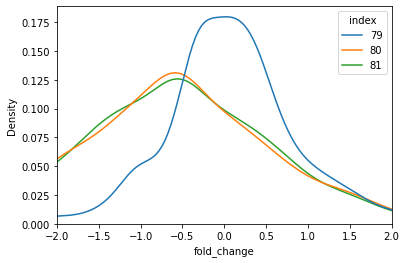

In [8]:
subset = dataset.loc[metadata[metadata.PXD_accession == "PXD006035"].index,:].fillna(0)
print(f"total identifications\n{(subset !=0).sum(axis = 1)}")
metadata[metadata.PXD_accession == "PXD006035"]
plot_fc(subset, 78)

In [69]:
metadata[metadata.PXD_accession == "PXD002057"]

assay_id cell_line PXD_accession tissue_type
142     31344     SKBR3     PXD002057      breast
143     31345     SKBR3     PXD002057      breast
144     31346     SKBR3     PXD002057      breast
145     31347     SKBR3     PXD002057      breast
146     31348     SKBR3     PXD002057      breast
147     31349     SKBR3     PXD002057      breast

In [5]:
metadata[metadata.PXD_accession == "PXD002842"]

assay_id cell_line PXD_accession tissue_type
46     31098      LAN5     PXD002842       brain
47     31099      LAN5     PXD002842       brain
48     31100      LAN5     PXD002842       brain
49     31101      LAN5     PXD002842       brain
50     31102      LAN5     PXD002842       brain
51     31103      LAN5     PXD002842       brain
52     31104      LAN5     PXD002842       brain
53     31105      LAN5     PXD002842       brain

total identifications
46     597
47     317
48    1051
49    1009
50    1435
51    1575
52    1618
53    1607
dtype: int64
46:	common prots: 472	medianFC: 0.2312652574894887	stdFC: 0.9601452479609746
47:	common prots: 279	medianFC: 0.037783344849873654	stdFC: 1.0159714130514532
49:	common prots: 796	medianFC: 0.14225014397617627	stdFC: 0.5848284888077635
50:	common prots: 893	medianFC: 0.02181422138935541	stdFC: 0.742165839753624
51:	common prots: 916	medianFC: 0.067330174340325	stdFC: 0.7861851600203368
52:	common prots: 922	medianFC: -0.13335590436982034	stdFC: 0.7584381265318723
53:	common prots: 926	medianFC: -0.17040336039231244	stdFC: 0.7819221603073974


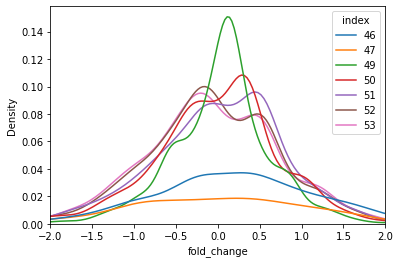

In [9]:
subset = dataset.loc[metadata[metadata.PXD_accession == "PXD002842"].index,:].fillna(0)
print(f"total identifications\n{(subset !=0).sum(axis = 1)}")
plot_fc(subset,48)

total identifications
142    1009
143    1570
144     811
145    1437
146     799
147    1480
158    4965
159    4970
160    5005
161    5176
162    5183
163    5244
164    4909
165    4851
166    4945
167    5187
168    5161
169    5240
170    4698
171    4682
172    5135
dtype: int64
common prots:  1982
142:	common prots: 874	medianFC: -0.6521547743906567
143:	common prots: 1358	medianFC: -0.41872523909607307
144:	common prots: 719	medianFC: -0.9243274609349705
145:	common prots: 1251	medianFC: -0.5192304960381062
146:	common prots: 703	medianFC: -0.864772782087179
147:	common prots: 1286	medianFC: -0.5040147264003308
158:	common prots: 3702	medianFC: -0.028606652543872072
159:	common prots: 3716	medianFC: -0.023710712857184076
160:	common prots: 3722	medianFC: -0.01245269191509574
161:	common prots: 3381	medianFC: -0.3156186010211316
162:	common prots: 3392	medianFC: -0.3111322115412727
163:	common prots: 3403	medianFC: -0.27419623283901884
164:	common prots: 3726	medianFC: -0.13587

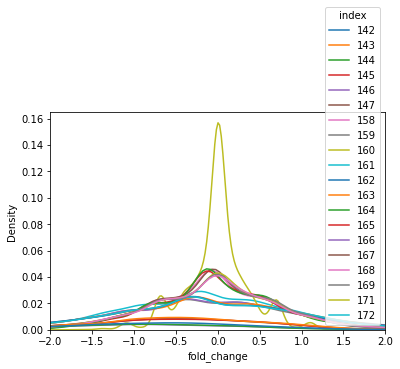

In [133]:
subset = dataset.loc[metadata[metadata.PXD_accession.isin(["PXD000661", "PXD002057"])].index,:].fillna(0)
print(f"total identifications\n{(subset !=0).sum(axis = 1)}")
print("common prots: ", all_ided.shape[1])
plot_fc(subset, 170)

common prots:  603


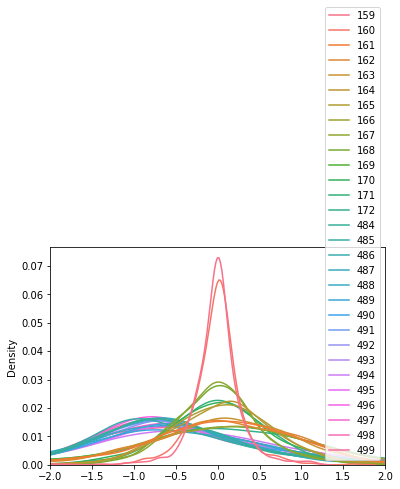

In [83]:
subset = dataset.loc[metadata[metadata.PXD_accession.isin("PXD008222 PXD000661".split())].index,:]
all_ided= subset.dropna(axis = 'columns')
print("common prots: ", all_ided.shape[1])
metadata[metadata.PXD_accession == "PXD008222"]
plot_fc(all_ided)

In [ ]:
subset = dataset.loc[metadata[metadata.PXD_accession == "PXD000661"].index,:]
all_ided= subset.dropna(axis = 'columns')
metadata[metadata.PXD_accession == "PXD000661"]

def plot_fc(subset, ref = None):
    """ref = index of the reference sample, default is first sample"""
    all_fc = {}
    if ref == None:
        ref = subset.loc[subset.index[0],:]
        ref_i = ref.name
    else:
        ref = subset.loc[ref,:]
        ref_i = ref.name

    for index, row in subset.iterrows():
        if index == ref_i:
            continue


        fc_list = []
        for i, protein in enumerate(row):
            fc_list.append(ref[i]/row[i])

        all_fc[index] = fc_list

    plt.xlim(right= 2, left = -2)
    sns.kdeplot(data=np.log(pd.DataFrame(all_fc)))

In [57]:
import math

def get_fc(sample1, sample2):
    '''returns list of fold changes of protein abundance between the 2 samples'''
    log_fc = []

    for i in range(len(sample1)):
        if sample1[i] != 0.0 and sample2[i] != 0.0:
            log_fc.append(sample1[i] / sample2[i])
    return log_fc

def compute_fc_within(on: list, data: pd.DataFrame, metadata, plot_all = True):
    '''on: column names to split upon (PXD_accession or tissue_type or both)
    
    within: 
    - true -> computes median log_fc wihtin the groups
    - false -> computes median log_fc for 1 sample in different groups pairwise
    '''

    median_logfcs = {}
    std_logfcs = {}
    plotting_fcs = {}

    groups = metadata.groupby(on).groups
    listed_groups = []

    for group, index_list in groups.items():
        if len(index_list) < 3:
            continue

        listed_groups.append(group)

        # Get a reference sample
        ref = data.loc[index_list[0],:]

        median_logfcs[group] = []
        std_logfcs[group] = []
    
        plotting_fcs[group] = pd.DataFrame(columns = ["index", "values"])

        for index in index_list[1:]:

            # Get sample to compare with
            sample = data.loc[index,:]

            # compute median and std
            fcs = get_fc(ref, sample)

            median_logfcs[group].append(np.median(fcs))
            std_logfcs[group].append(np.std(fcs))

            sample_fcs = pd.DataFrame({"values": fcs})
            sample_fcs["index"] = index
            plotting_fcs[group] = pd.concat([plotting_fcs[group], sample_fcs]).reset_index(drop = True)

    counter = 0
    print("plotting...")

    fig, ax = plt.subplots(math.ceil(len(listed_groups)/5), 5, figsize = (25, 10*math.ceil(len(listed_groups))/5))
    
    for row in range(math.ceil(len(listed_groups)/5)):
        for col in range(5):


            ax[row, col].set_xlim(left = -2)
            ax[row, col].set_xlim(right = 2)
            ax[row, col].title.set_text(listed_groups[counter])
            sns.kdeplot(data = plotting_fcs[listed_groups[counter]], x = "values", hue = "index", ax=ax[row,col])
            counter += 1
            if counter == len(listed_groups):
                break
    plt.show()
    return median_logfcs, std_logfcs

def compute_fc_between(data, metadata, reference_pxd):
    pxd_index = metadata.groupby("PXD_accession").groups
    reference = data.loc[pxd_index[reference_pxd][0],:]

    

plotting...


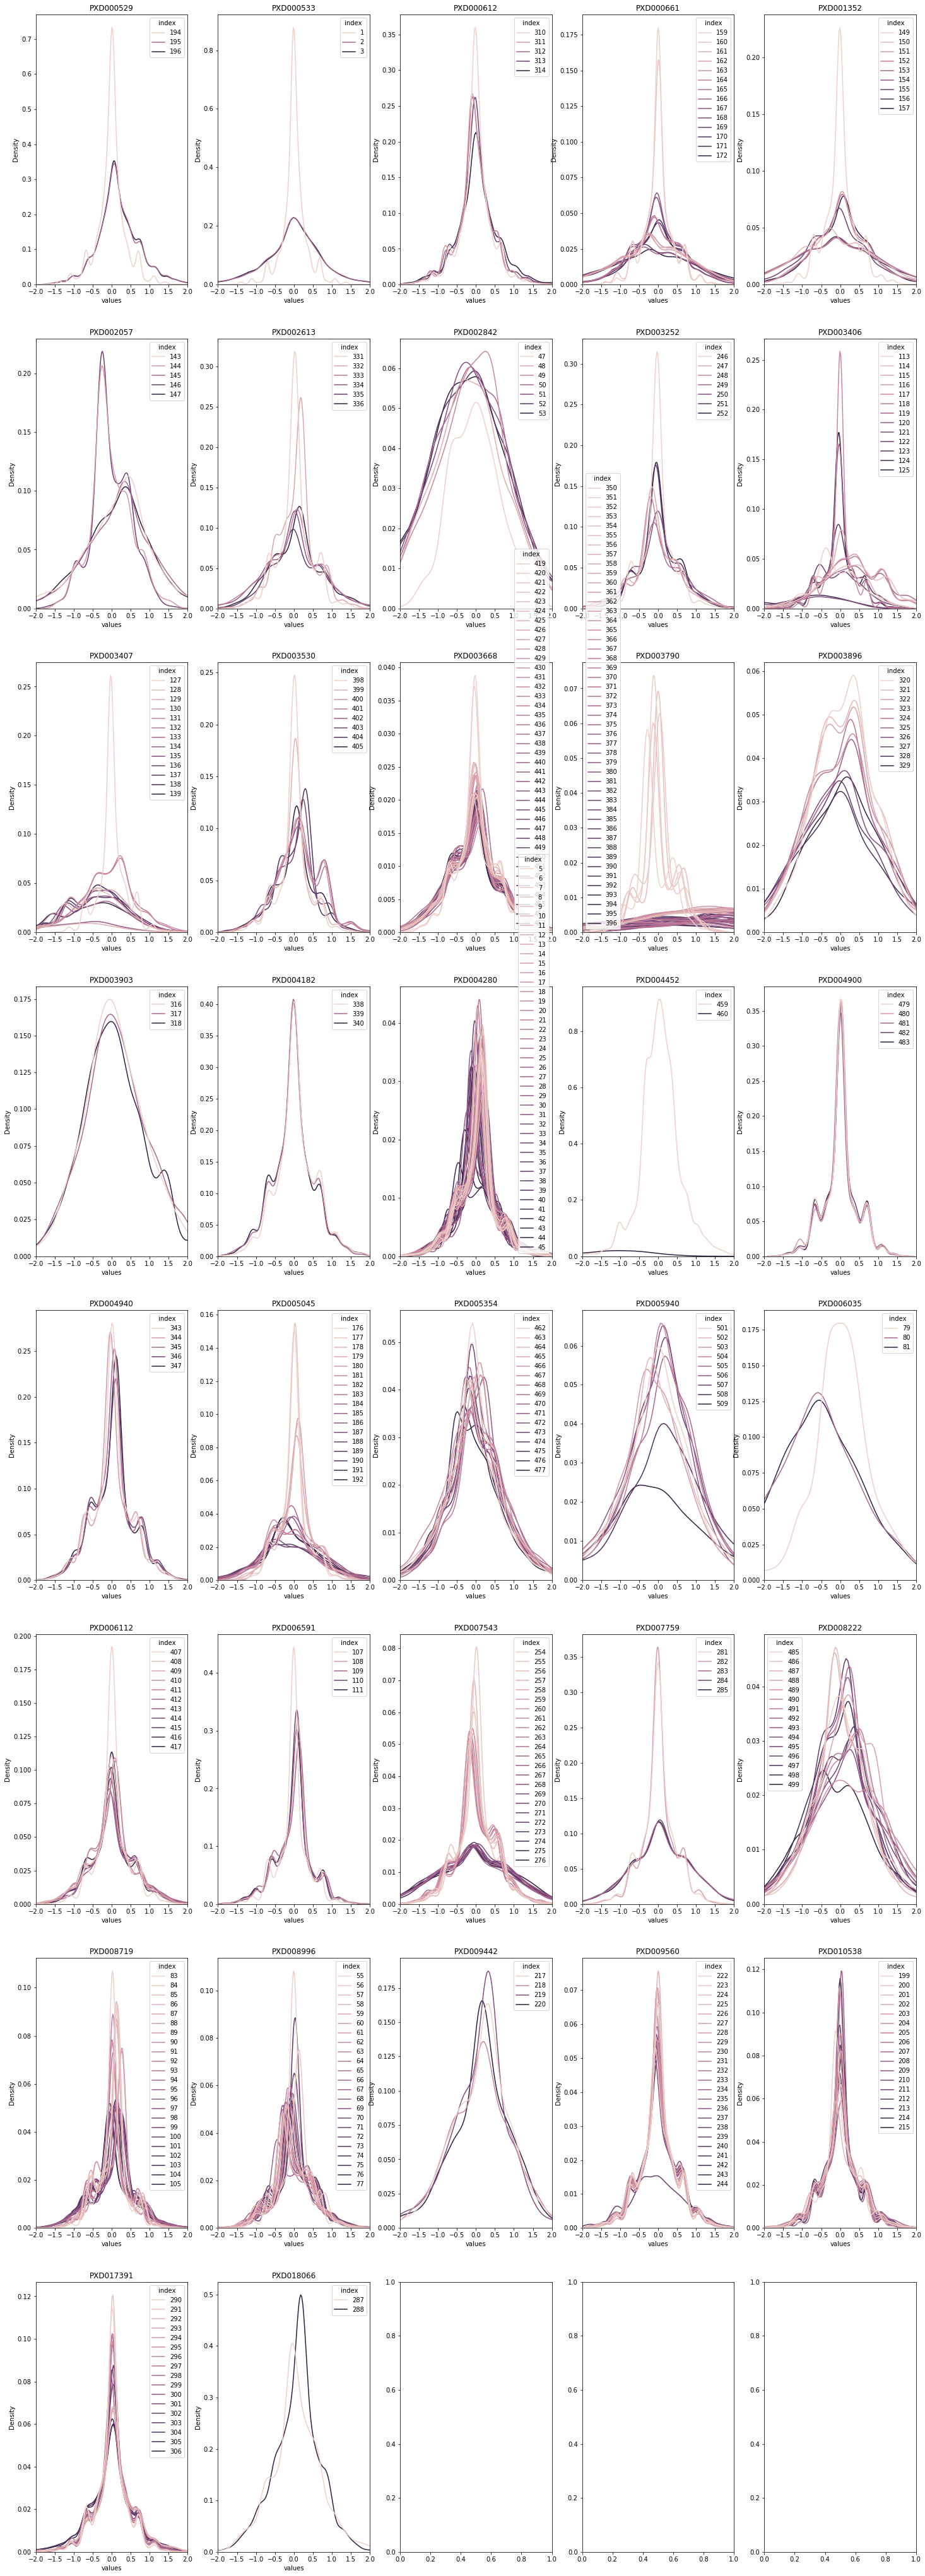

In [128]:
median_, std_ = compute_fc_within(['PXD_accession'], dataset.fillna(0), metadata)

In [77]:
list(metadata.groupby("PXD_accession").groups.keys())[0]

'PXD000426'

<AxesSubplot:ylabel='Density'>

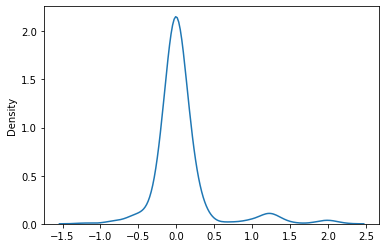

In [134]:
all_fcs = []
for fcs in median_.values():
    all_fcs += fcs
sns.kdeplot(all_fcs)

<AxesSubplot:ylabel='Density'>

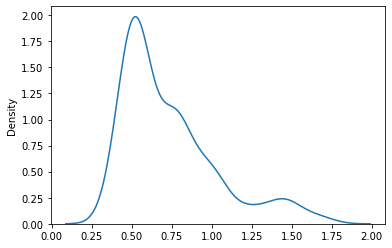

In [133]:
all_fcs = []
for fcs in std_.values():
    all_fcs += fcs
sns.kdeplot(all_fcs)

In [158]:
between = pd.DataFrame(columns = ["index", "values"])
for x in range(170,173):
    print(x)
    df = pd.DataFrame({"values": get_fc(dataset.loc[384,:].fillna(0), dataset.loc[x,:].fillna(0))})
    df["index"] = x
    between = pd.concat([between, df])


170
171
172


<AxesSubplot:xlabel='values', ylabel='Density'>

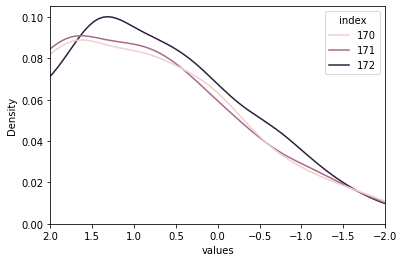

In [159]:
plt.xlim((2,-2))
sns.kdeplot(data = between.reset_index(drop = True), x = "values", hue = "index")

plotting...


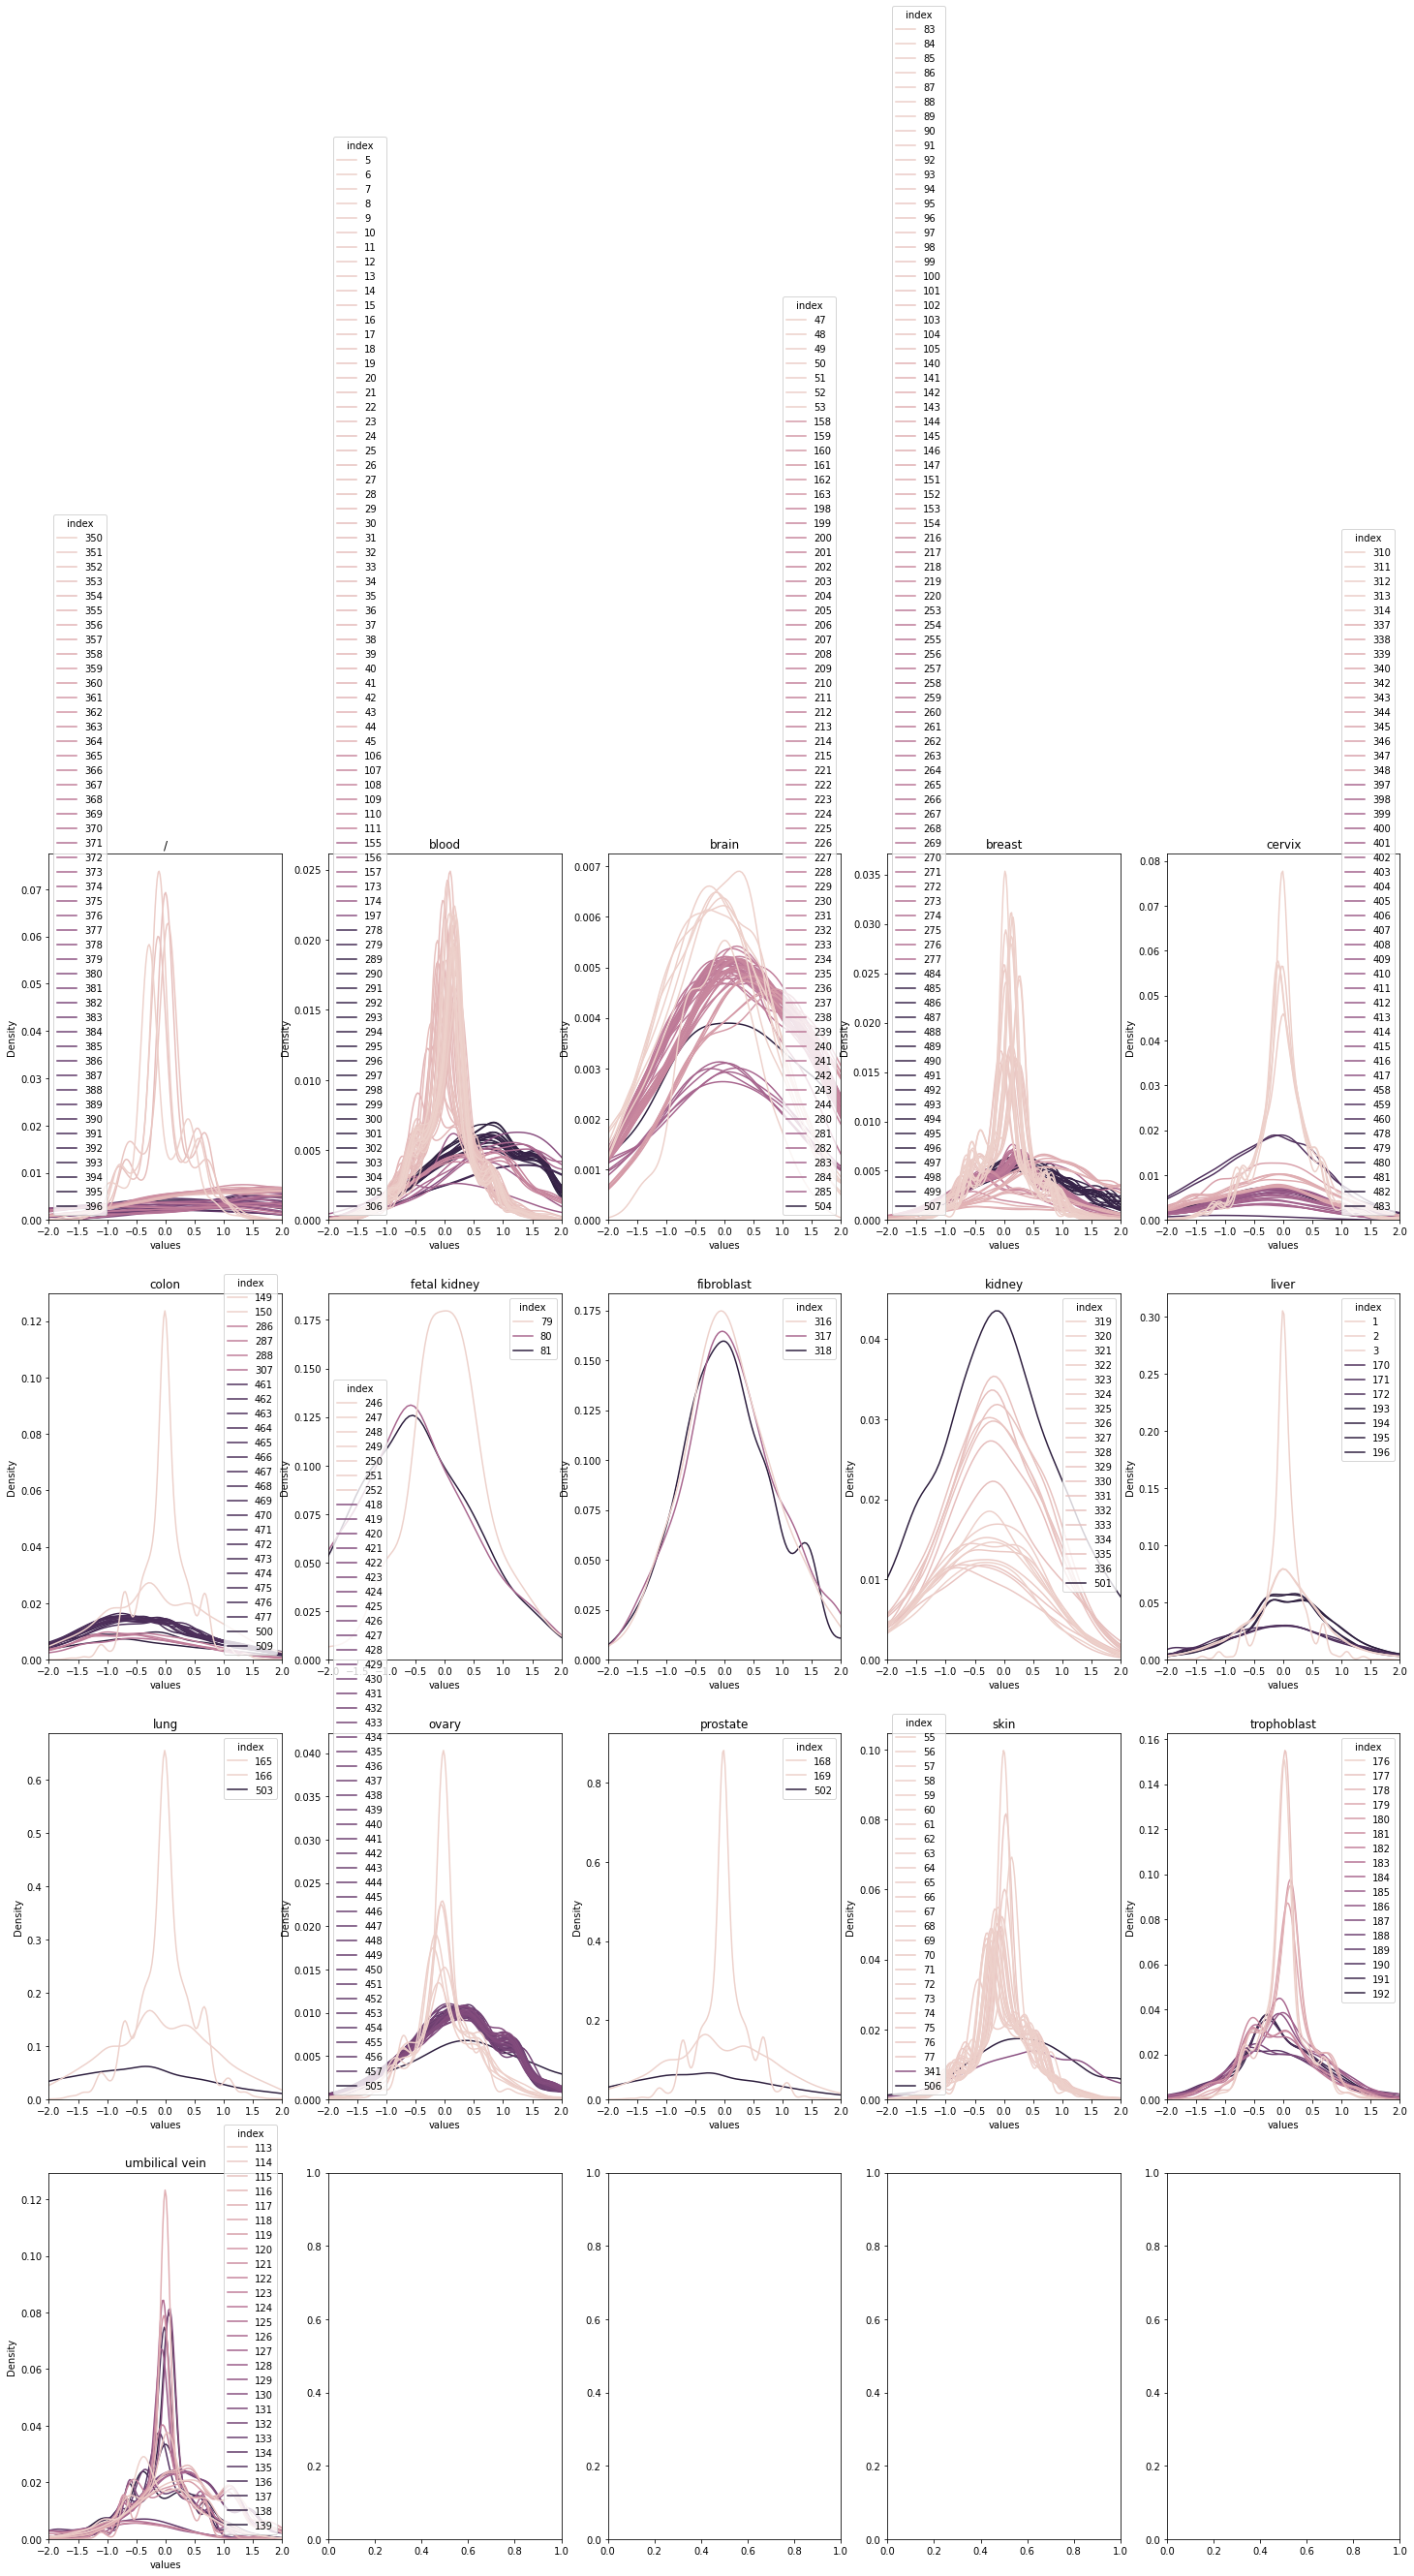

In [160]:
median_, std_ = compute_fc_within(['tissue_type'], dataset.fillna(0), metadata)

Taking 1 sample as reference per project, the median fold change per mutually identified protein is calculated pairwise for every sample in the project. <br>
Subsequently, fold change is calculated across projects to detect a systematic difference. <br>
If this proves to be the case, the abundances will be corrected by multiplying each protein in a project by 1/median(fc) <br>

Question: dealing with difference in variance of the fc as well?

With following formula, every mean and variance can be set equal: yi= m2 + (xi−m1) * s2s1 with m2 and s2 the target mean and std.

<AxesSubplot:xlabel='values', ylabel='Density'>

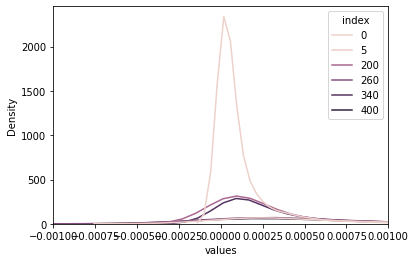

In [29]:
values = pd.DataFrame(columns = ["values","index"])
for x in [0, 5, 200, 260, 340, 400]:
    df = pd.DataFrame({"values":dataset.loc[x,dataset.loc[x,:].notna()]})
    df["index"] = x
    values = pd.concat([values, df])

plt.xlim((-0.001,0.001))
sns.kdeplot(data = values.reset_index(drop = True), x = "values", hue = "index")

<AxesSubplot:>

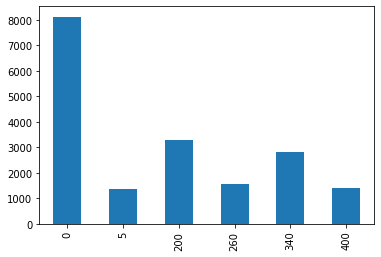

In [16]:
dataset.loc[metadata[metadata.index.isin("0 5 200 260 340 400".split())].index,:].notna().sum(axis = 1).plot(kind = "bar")

In [83]:
def recalculate(value, mean, std):
    return 1+ (value - mean)*(1/std)

In [84]:
count = 0
new_df = {}
for i, row in dataset.iterrows():
    meann = np.mean(row)
    stdd = np.std(row)
    
    new_row = []
    for protein in row:
        if np.isnan(protein):
            new_row.append(np.nan)
        else:
            new_row.append(recalculate(protein, meann, stdd))

    new_df[i] = new_row
    

In [85]:
rescaled_df = pd.DataFrame(new_df, index = dataset.columns).T

In [88]:
rescaled_df

A0A024RBG1  A0A075B6X5  A0A096LP01  A0A096LP49  A0A0A6YYK6  A0A0B4J1V0  \
0      0.597636         NaN         NaN         NaN         NaN         NaN   
1           NaN         NaN         NaN         NaN         NaN         NaN   
2      0.644027         NaN    0.801177         NaN         NaN    0.661389   
3      0.645056         NaN    0.861533         NaN         NaN    0.662090   
4           NaN         NaN         NaN         NaN         NaN         NaN   
..          ...         ...         ...         ...         ...         ...   
505         NaN         NaN         NaN         NaN         NaN         NaN   
506    0.879423         NaN         NaN         NaN         NaN         NaN   
507         NaN         NaN         NaN         NaN         NaN         NaN   
508         NaN         NaN         NaN         NaN         NaN         NaN   
509         NaN         NaN         NaN         NaN         NaN         NaN   

     A0A0B4J2F0  A0A0J9YWL9  A0A0J9YX94  A0A0U1RRE5  ...    Q9Y6X4    Q9Y6X5  \
0           NaN         NaN         NaN         NaN  ...  0.810885  0.618814   
1           NaN         NaN         NaN         NaN  ...  0.803632  0.619540   
2           NaN    0.616776         NaN         NaN  ...       NaN       NaN   
3           NaN    0.618320         NaN         NaN  ...       NaN       NaN   
4           NaN         NaN         NaN         NaN  ...       NaN       NaN   
..          ...         ...         ...         ...  ...       ...       ...   
505         NaN         NaN         NaN         NaN  ...       NaN  0.670371   
506         NaN         NaN         NaN         NaN  ...       NaN       NaN   
507         NaN         NaN         NaN         NaN  ...       NaN       NaN   
508    0.834025         NaN         NaN         NaN  ...       NaN       NaN   
509    0.893625         NaN         NaN         NaN  ...       NaN       NaN   

       Q9Y6X8    Q9Y6X9    Q9Y6Y0    Q9Y6Y1    Q9Y6Y8    Q9Y6Y9  Q9Y6Z7  \
0    0.661755  0.705038  0.781808       NaN  0.876204       NaN     NaN   
1    0.678297  0.712776  0.723545  0.566334  0.827459       NaN     NaN   
2    0.632321  0.686683  0.751630       NaN  0.900224  0.686099     NaN   
3    0.626501  0.721313  0.713757       NaN  0.849074  0.686334     NaN   
4         NaN       NaN       NaN       NaN  0.653643       NaN     NaN   
..        ...       ...       ...       ...       ...       ...     ...   
505  0.672151  0.838320  0.816354       NaN  1.167130       NaN     NaN   
506       NaN  0.777392  0.749421       NaN  1.039938       NaN     NaN   
507  0.972171  0.986319  0.602012       NaN  1.152394       NaN     NaN   
508  0.717606  0.680153       NaN       NaN  0.690009       NaN     NaN   
509  0.631312  0.862651  0.707563       NaN  0.961483       NaN     NaN   

     W5XKT8  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
..      ...  
505     NaN  
506     NaN  
507     NaN  
508     NaN  
509     NaN  

[510 rows x 13166 columns]

In [89]:
rescaled_df.to_csv("rescaled_dataset.csv")

<AxesSubplot:xlabel='values', ylabel='Density'>

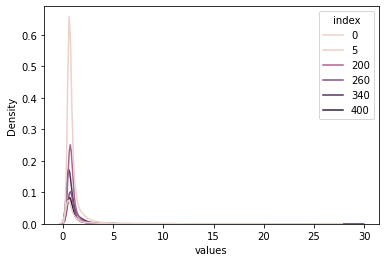

In [87]:
values = pd.DataFrame(columns = ["values","index"])
for x in [0, 5, 200, 260, 340, 400]:
    df = pd.DataFrame({"values":rescaled_df.loc[x,rescaled_df.loc[x,:].notna()]})
    df["index"] = x
    values = pd.concat([values, df])


sns.kdeplot(data = values.reset_index(drop = True), x = "values", hue = "index")

plotting...


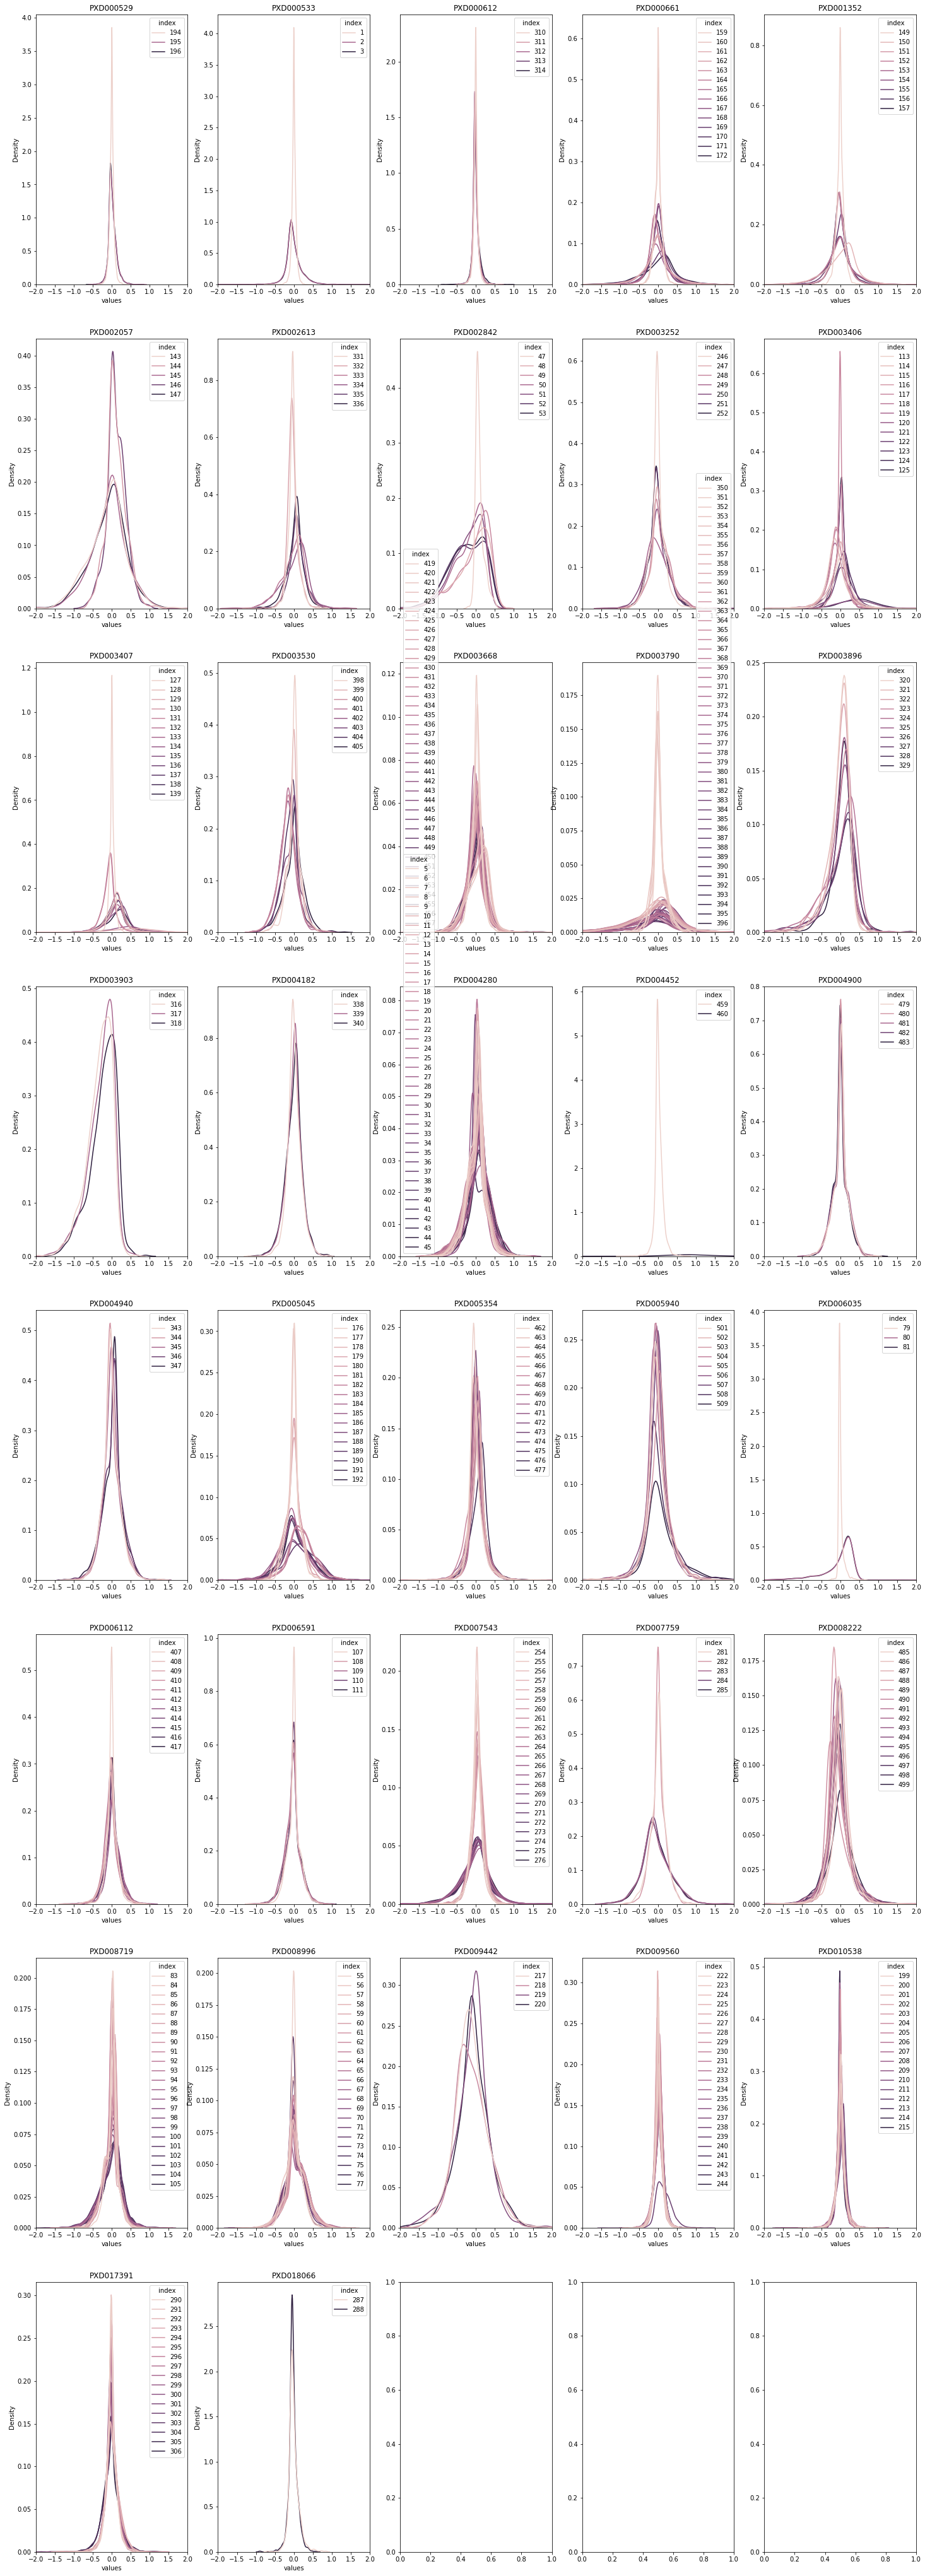

In [90]:
median_, std_ = compute_fc_within(['PXD_accession'], rescaled_df.fillna(0), metadata)

170
171
172


<AxesSubplot:xlabel='values', ylabel='Density'>

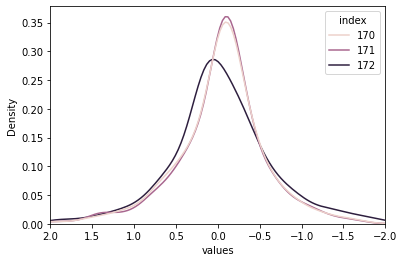

In [91]:
between = pd.DataFrame(columns = ["index", "values"])
for x in range(170,173):
    print(x)
    df = pd.DataFrame({"values": get_fc(rescaled_df.loc[384,:].fillna(0), rescaled_df.loc[x,:].fillna(0))})
    df["index"] = x
    between = pd.concat([between, df])
plt.xlim((2,-2))
sns.kdeplot(data = between.reset_index(drop = True), x = "values", hue = "index")

---

Method 2: do it like FlashLFQ --> take 1 sample as ref in a project, calculate the median fold change of the protiens and multiply every value by 1/medianFC

In [58]:
def return_shifted_sample(sample1, sample2):
    '''returns sample 2 with recalculated values'''
    fc = []

    for i in range(len(sample1)):
        if sample1[i] != 0.0 and sample2[i] != 0.0:
            fc.append(sample1[i] / sample2[i])

    med_fc = np.median(fc)
    if med_fc > 1.1 or med_fc < .91:
        return sample2 * med_fc
    return sample2


In [ ]:
# Test this with PXD002057 (change caused by cell variant: AZD8931 resistance)

total identifications
142    1009
143    1570
144     811
145    1437
146     799
147    1480
dtype: int64
143:	common prots: 699	medianFC: 0.2576811366782801	stdFC: 0.9020387761772387
144:	common prots: 672	medianFC: -0.1465154724038611	stdFC: 0.5350845053213165
145:	common prots: 667	medianFC: 0.35606782966675965	stdFC: 0.8929549210154407
146:	common prots: 681	medianFC: -0.15604765620812824	stdFC: 0.5152194765567539
147:	common prots: 679	medianFC: 0.37128359930453475	stdFC: 0.8968400559677046


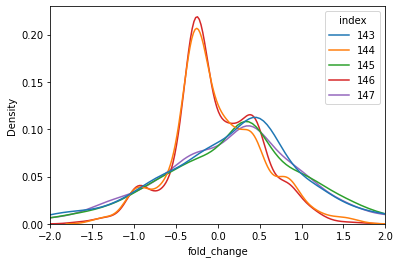

In [51]:
subset = dataset.loc[metadata[metadata.PXD_accession == "PXD002057"].index,:].fillna(0)
print(f"total identifications\n{(subset !=0).sum(axis = 1)}")
metadata[metadata.PXD_accession == "PXD002057"]
plot_fc(subset)

In [52]:
subset_r = dataset.loc[metadata[metadata.PXD_accession == "PXD002057"].index,:].fillna(0)

flag = True
for index, row in subset_r.iterrows():
    if flag:
        ref = row
        flag = False
        continue

    subset_r.loc[index,:] = return_shifted_sample(ref, row)


143:	common prots: 699	medianFC: -1.1102230246251565e-16	stdFC: 0.9020387761772387
144:	common prots: 672	medianFC: -3.100102304352554e-05	stdFC: 0.5350845053213165
145:	common prots: 667	medianFC: 0.0	stdFC: 0.8929549210154406
146:	common prots: 681	medianFC: 0.0	stdFC: 0.5152194765567539
147:	common prots: 679	medianFC: 0.0	stdFC: 0.8968400559677046


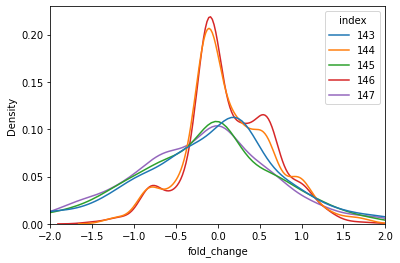

In [53]:
plot_fc(subset_r)

# what to do with standard deviation?

total identifications
78    1423
79    1188
80    2032
81    2034
dtype: int64
79:	common prots: 957	medianFC: 0.0	stdFC: 0.7837981877924751
80:	common prots: 1078	medianFC: 0.0	stdFC: 1.2056974247259575
81:	common prots: 1083	medianFC: 0.0	stdFC: 1.2011670153879006


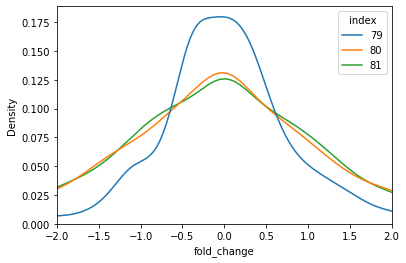

In [37]:
subset_r = dataset.loc[metadata[metadata.PXD_accession == "PXD006035"].index,:].fillna(0)

flag = True
for index, row in subset_r.iterrows():
    if flag:
        ref = row
        flag = False
        continue

    subset_r.loc[index,:] = return_shifted_sample(ref, row)

print(f"total identifications\n{(subset_r !=0).sum(axis = 1)}")
plot_fc(subset_r)

79:	common prots: 957	medianFC: 0.05866676187898785	stdFC: 0.7837981877924751
80:	common prots: 1078	medianFC: -0.5645227661195336	stdFC: 1.2056974247259575
81:	common prots: 1083	medianFC: -0.5602855925139116	stdFC: 1.2011670153879006


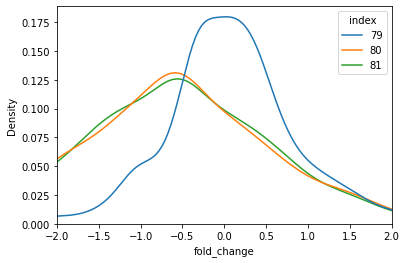

In [192]:
subset_r = dataset.loc[metadata[metadata.PXD_accession == "PXD006035"].index,:].fillna(0)
plot_fc(subset_r)

<AxesSubplot:ylabel='Density'>

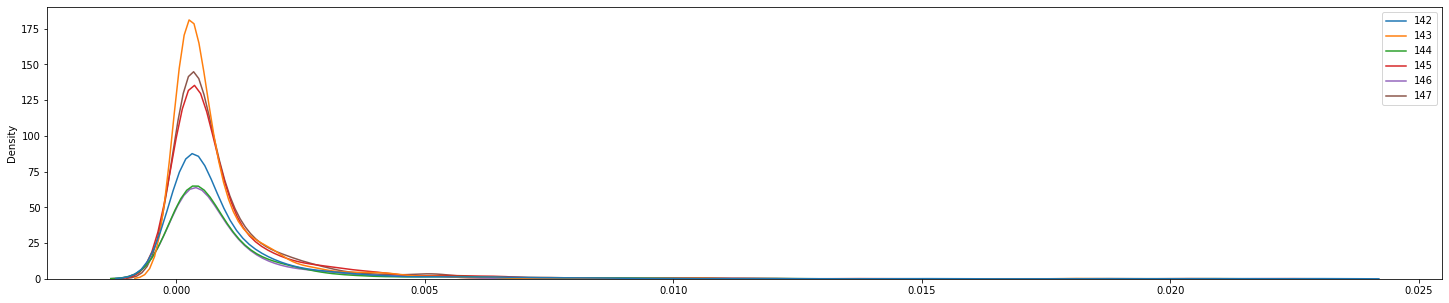

In [68]:
plt.figure(figsize = (25,5))
sns.kdeplot(data=subset_r.replace(0,np.nan).T)

<AxesSubplot:>

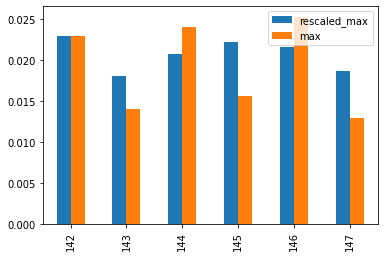

In [84]:
comparison_scaling_df = pd.DataFrame(subset_r.max(axis = 1).rename("rescaled_max"))
pd.concat([comparison_scaling_df, subset.max(axis = 1).rename("max")], axis = 1).plot(kind = "bar")

<AxesSubplot:>

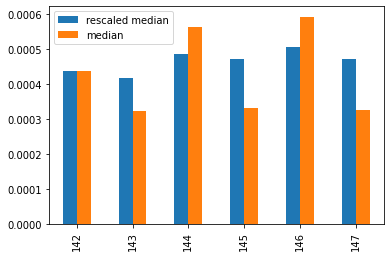

In [89]:
pd.concat([subset_r.replace(0,np.nan).median(axis = 1).rename("rescaled median"),subset.replace(0,np.nan).median(axis = 1).rename("median")], axis = 1).plot(kind = "bar")

Test looks cool, now do it for all of them

In [91]:
dataset

A0A024RBG1  A0A075B6X5  A0A096LP01  A0A096LP49  A0A0A6YYK6  A0A0B4J1V0  \
0      0.000010         NaN         NaN         NaN         NaN         NaN   
1           NaN         NaN         NaN         NaN         NaN         NaN   
2      0.000011         NaN    0.000061         NaN         NaN    0.000016   
3      0.000011         NaN    0.000080         NaN         NaN    0.000016   
4           NaN         NaN         NaN         NaN         NaN         NaN   
..          ...         ...         ...         ...         ...         ...   
505         NaN         NaN         NaN         NaN         NaN         NaN   
506    0.000189         NaN         NaN         NaN         NaN         NaN   
507         NaN         NaN         NaN         NaN         NaN         NaN   
508         NaN         NaN         NaN         NaN         NaN         NaN   
509         NaN         NaN         NaN         NaN         NaN         NaN   

     A0A0B4J2F0  A0A0J9YWL9  A0A0J9YX94  A0A0U1RRE5  ...    Q9Y6X4    Q9Y6X5  \
0           NaN         NaN         NaN         NaN  ...  0.000070  0.000016   
1           NaN         NaN         NaN         NaN  ...  0.000068  0.000016   
2           NaN    0.000002         NaN         NaN  ...       NaN       NaN   
3           NaN    0.000002         NaN         NaN  ...       NaN       NaN   
4           NaN         NaN         NaN         NaN  ...       NaN       NaN   
..          ...         ...         ...         ...  ...       ...       ...   
505         NaN         NaN         NaN         NaN  ...       NaN  0.000018   
506         NaN         NaN         NaN         NaN  ...       NaN       NaN   
507         NaN         NaN         NaN         NaN  ...       NaN       NaN   
508    0.000169         NaN         NaN         NaN  ...       NaN       NaN   
509    0.000338         NaN         NaN         NaN  ...       NaN       NaN   

       Q9Y6X8    Q9Y6X9    Q9Y6Y0    Q9Y6Y1    Q9Y6Y8    Q9Y6Y9  Q9Y6Z7  \
0    0.000028  0.000040  0.000062       NaN  0.000088       NaN     NaN   
1    0.000033  0.000042  0.000045  0.000001  0.000075       NaN     NaN   
2    0.000007  0.000024  0.000045       NaN  0.000092  0.000024     NaN   
3    0.000005  0.000035  0.000033       NaN  0.000076  0.000024     NaN   
4         NaN       NaN       NaN       NaN  0.000350       NaN     NaN   
..        ...       ...       ...       ...       ...       ...     ...   
505  0.000020  0.000161  0.000143       NaN  0.000441       NaN     NaN   
506       NaN  0.000124  0.000107       NaN  0.000291       NaN     NaN   
507  0.000270  0.000279  0.000024       NaN  0.000389       NaN     NaN   
508  0.000054  0.000018       NaN       NaN  0.000027       NaN     NaN   
509  0.000022  0.000300  0.000114       NaN  0.000419       NaN     NaN   

     W5XKT8  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
..      ...  
505     NaN  
506     NaN  
507     NaN  
508     NaN  
509     NaN  

[510 rows x 13166 columns]

In [60]:
shifted_dataset = dataset.copy()

In [61]:
shifted_dataset.fillna(0,inplace  = True)

In [62]:
# 1 project at a time
for pxd in metadata.PXD_accession.unique():
    indices = metadata[metadata.PXD_accession == pxd].index

    if len(indices) < 2:
        continue
    
    # Loop over the indices
    flag = True
    for index, row in shifted_dataset.loc[indices,:].iterrows():
        if flag:
            ref = row
            flag = False
            continue

        shifted_dataset.loc[index,:] = return_shifted_sample(ref, row)



158:	common prots: 3702	medianFC: -0.028606652543872072	stdFC: 0.8598096855112672
159:	common prots: 3716	medianFC: -0.023710712857184076	stdFC: 0.846712150582612
160:	common prots: 3722	medianFC: -0.01245269191509574	stdFC: 0.834284525397215
161:	common prots: 3381	medianFC: -0.10567329344640153	stdFC: 1.1132179212878268
162:	common prots: 3392	medianFC: -0.08505400624366559	stdFC: 1.1136479540229796
163:	common prots: 3403	medianFC: -0.046832793423467974	stdFC: 1.1043918526475083
164:	common prots: 3726	medianFC: 0.00925667322757516	stdFC: 0.7934730000283896
165:	common prots: 3694	medianFC: -0.010516947962817057	stdFC: 0.8008804764269766
166:	common prots: 3362	medianFC: 0.12104807921569151	stdFC: 1.080218099783074
167:	common prots: 3809	medianFC: 0.07902989485462321	stdFC: 0.8257503365090259
168:	common prots: 3805	medianFC: 0.07789754277199643	stdFC: 0.8297106876513447
169:	common prots: 3400	medianFC: 0.08929938090111134	stdFC: 1.1287686130561763
171:	common prots: 4209	medianFC

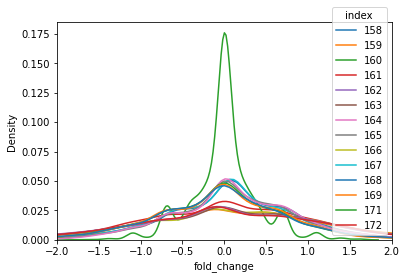

In [163]:
subset = shifted_dataset.loc[metadata[metadata.PXD_accession == "PXD000661"].index,:].fillna(0)
#metadata[metadata.PXD_accession == "PXD000661"]
plot_fc(subset, 170)

<AxesSubplot:>

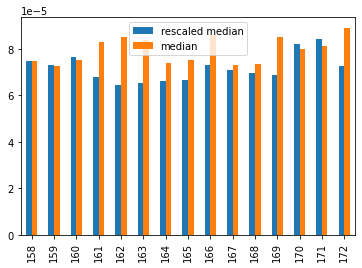

In [108]:
subset_r = shifted_dataset.loc[metadata[metadata.PXD_accession == "PXD000661"].index,:]
subset = dataset.loc[metadata[metadata.PXD_accession == "PXD000661"].index,:]
pd.concat([subset_r.replace(0,np.nan).median(axis = 1).rename("rescaled median"),subset.replace(0,np.nan).median(axis = 1).rename("median")], axis = 1).plot(kind = "bar")

---

4:	common prots: 1142	medianFC: -0.05025916785552102	stdFC: 0.9307709801403795
106:	common prots: 1730	medianFC: -0.10008345855698217	stdFC: 0.8669905254130055
107:	common prots: 1720	medianFC: -0.009111680351255721	stdFC: 0.8864446446428018
108:	common prots: 1786	medianFC: 0.017699577099400857	stdFC: 0.8829965972481111
109:	common prots: 1852	medianFC: -0.0034381644747180566	stdFC: 0.8920386671148524
110:	common prots: 1788	medianFC: -0.03702532258984558	stdFC: 0.8744453153046079
111:	common prots: 1798	medianFC: -0.031090587070031005	stdFC: 0.8734805065107286
155:	common prots: 2162	medianFC: 0.06161881103423617	stdFC: 1.172559211328096
156:	common prots: 2265	medianFC: 0.07338848295998951	stdFC: 1.2155367333613531
157:	common prots: 2167	medianFC: -0.025722256224721764	stdFC: 1.15617568410283
173:	common prots: 860	medianFC: -0.10008345855698272	stdFC: 1.0434238183769322
174:	common prots: 1522	medianFC: 0.0822380982369716	stdFC: 0.9607832296239015
197:	common prots: 2618	medianFC:

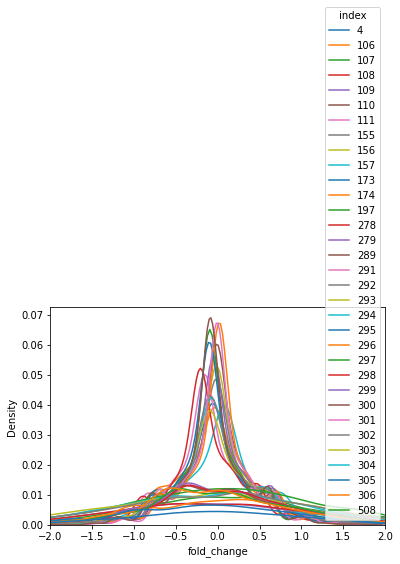

In [182]:
subset = shift_tissue_df.loc[metadata[metadata.tissue_type == "blood"].index,:]
subset.drop(range(5,46), axis = 0, inplace = True)
subset = subset.dropna(axis = "columns")
#metadata[metadata.PXD_accession == "PXD000661"]
plot_fc(subset,290)

In [64]:
shift_tissue_df = shifted_dataset.copy()

In [65]:
# 1 project at a time

for tissue in metadata.tissue_type.unique():

    indices = metadata[metadata.tissue_type == tissue].index

    flag = True
    for pxd in metadata.loc[indices,:].PXD_accession.unique():
        
        if flag:
            ref = shifted_dataset.loc[metadata.PXD_accession == pxd].iloc[0,:]
            flag = False
            pxd_ref = pxd
            continue


        for index, row in shifted_dataset.loc[metadata.PXD_accession == pxd].iterrows():
            shift_tissue_df.loc[index,:] = return_shifted_sample(ref, row)
        
        print(f"shifted: {pxd_ref} - {pxd}")

shifted: PXD000533 - PXD000661
shifted: PXD000533 - PXD000529
shifted: PXD004280 - PXD006591
shifted: PXD004280 - PXD001352
shifted: PXD004280 - PXD008381
shifted: PXD004280 - PXD000443
shifted: PXD004280 - PXD000426
shifted: PXD004280 - PXD017391
shifted: PXD004280 - PXD005940
shifted: PXD002842 - PXD000661
shifted: PXD002842 - PXD010538
shifted: PXD002842 - PXD009560
shifted: PXD002842 - PXD007759
shifted: PXD002842 - PXD005940
shifted: PXD008996 - PXD005912
shifted: PXD008996 - PXD005940
shifted: PXD008719 - PXD001327
shifted: PXD008719 - PXD002057
shifted: PXD008719 - PXD001352
shifted: PXD008719 - PXD009442
shifted: PXD008719 - PXD007543
shifted: PXD008719 - PXD008693
shifted: PXD008719 - PXD008222
shifted: PXD008719 - PXD005940
shifted: PXD003406 - PXD003407
shifted: PXD001352 - PXD018066
shifted: PXD001352 - PXD016742
shifted: PXD001352 - PXD005354
shifted: PXD001352 - PXD005940
shifted: PXD000661 - PXD005940
shifted: PXD000661 - PXD005940
shifted: PXD003252 - PXD003668
shifted:

83:	common prots: 1425	medianFC: 0.00884961527698238	stdFC: 0.38342004980634997
84:	common prots: 1470	medianFC: 0.0958609922666123	stdFC: 0.4126389796342092
85:	common prots: 1488	medianFC: 0.07784248676393393	stdFC: 0.4169400363809032
86:	common prots: 1468	medianFC: 0.04275116695266369	stdFC: 0.4433009267580322
87:	common prots: 1454	medianFC: 0.07784248676393393	stdFC: 0.43245767321687445
88:	common prots: 1458	medianFC: 0.15195045891765577	stdFC: 0.4595584263616846
89:	common prots: 1457	medianFC: 0.1366829867868672	stdFC: 0.455279835174239
90:	common prots: 1407	medianFC: -0.03463549666275611	stdFC: 0.4586156002239099
91:	common prots: 1413	medianFC: 0.0088496152769826	stdFC: 0.42643350646943484
92:	common prots: 1402	medianFC: 0.00884961527698238	stdFC: 0.4554852965340539
93:	common prots: 1426	medianFC: 0.00884961527698238	stdFC: 0.476669997237412
94:	common prots: 1352	medianFC: 0.11421013093480897	stdFC: 0.5628165762429823
95:	common prots: 1348	medianFC: 0.07784248676393393	

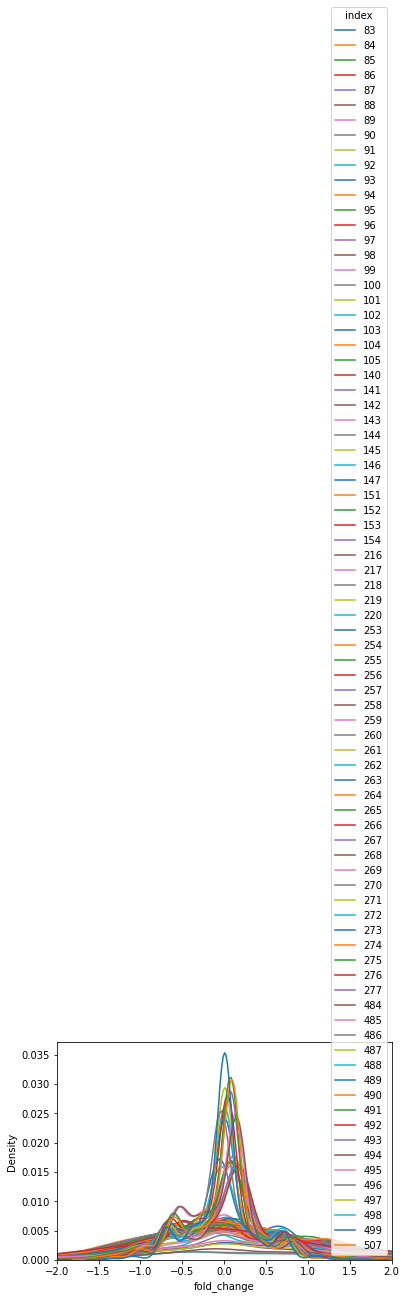

In [180]:
subset = shift_tissue_df.loc[metadata[metadata.tissue_type == "breast"].index,:].fillna(0)
#metadata[metadata.PXD_accession == "PXD000661"]
plot_fc(subset)